# Compute the time slices and GWLs for wind CORDEX

### Author: Jerome Servonat
### Contact: jerome.servonnat at lsce.ipsl.fr

### Import CliMAF

In [1]:
from climaf.api import *

CliMAF version = 1.2.13


CliMAF install => /ciclad-home/jservon/Evaluation/CliMAF/climaf_installs/climaf_V1.2.13_post
python => /modfs/modtools/miniconda2/envs/analyse_2.7_v2/bin/python
---
Required softwares to run CliMAF => you are using the following versions/installations:
ncl 6.6.2 => /modfs/modtools/miniconda2/envs/analyse_2.7_v2/bin/ncl
cdo 1.9.6 => /opt/nco/1.9/bin/cdo
nco (ncks) 4.5.2 => /opt/nco-4.5.2/bin/ncks
ncdump fichier => /modfs/modtools/miniconda2/envs/analyse_2.7_v2/bin/ncdump
Check stamping requirements
nco (ncatted) found -> /opt/nco-4.5.2/bin/ncatted
convert found -> /usr/bin/convert
pdftk found -> /usr/bin/pdftk
exiv2 found -> /ciclad-home/jservon/Evaluation/CliMAF/climaf_installs/climaf_V1.2.13_post/bin/exiv2
---


Cache directory set to : /data/jservon/climafcache (use $CLIMAF_CACHE if set) 
Cache directory for remote data set to : /data/jservon/climafcache/remote_data (use $CLIMAF_REMOTE_CACHE if set) 
Available macros read from ~/.climaf.macros are : []


## 1. Copmpute averages for baseline and future periods for 26 and 85

In [2]:
lom_per_exp = dict()

In [ ]:
# List all the GCM_RCM realization per CORDEX_domain, for historical, rcp26 and rcp85

In [3]:
from natsort import natsorted

req_dict = dict(project='CORDEX',
                frequency='mon',
                table = 'Lmon',
                version='latest'
               )

exp_dict_list = dict(
    historical = dict(experiment='historical',
         period='2000'
        ),
    rcp85 = dict(experiment='rcp85',
         period='2050'
        ),
    rcp26 = dict(experiment='rcp26',
         period='2050'
        ),
    #baseline_ext = dict(experiment='rcp85',
    #     period='2006-2015'
    #    ),
    #rcp26_mid = dict(experiment='rcp26',
    #     period='2041-2060'
    #    ),
    #rcp26_far = dict(experiment='rcp26',
    #     period='2081-2100'
    #    ),
    #rcp85_mid = dict(experiment='rcp85',
    #     period='2041-2060'
    #    ),
    #rcp85_far = dict(experiment='rcp85',
    #     period='2081-2100'
    #    )  
)

CORDEX_domains = [
    # -- Africa
    'AFR-44','AFR-22',
    # -- AustralAsia
    'AUS-44','AUS-22',
    # -- Central America
    'CAM-44','CAM-22',
    # -- North America
    'NAM-44','NAM-22',
    # -- South America
    'SAM-44','SAM-22',
    # -- Asia
    'EAS-44','EAS-22',
    'WAS-44','WAS-22',
    'SEA-22',
    # -- Europe
    'EUR-11',
    
]

In [5]:
listing_ens_exp_dict = dict()
clog('critical')

for CORDEX_domain in CORDEX_domains:

    listing_ens_exp_dict[CORDEX_domain] = dict()
    
    for exp in exp_dict_list:
        listing_ens_exp_dict[CORDEX_domain][exp] = dict()
        print exp
        wreq = req_dict.copy()
        wreq.update(exp_dict_list[exp])

        req = ds(driving_model = '*',
                 model = '*',
                 realization = '*',
                 CORDEX_domain = CORDEX_domain,
                 variable = 'mrso',
                 **wreq
                )
        choices = req.explore('choices')
        if 'driving_model' in choices:
            for GCM in choices['driving_model']:
                for RCM in choices['model']:
                    GCM_RCM = GCM+'_'+RCM
                    model_version = None
                    req2 = ds(driving_model = GCM,
                             model = RCM,
                             realization = '*',
                             CORDEX_domain = CORDEX_domain,
                             variable = 'mrso',
                             **wreq
                            )
                    req2_choices = req2.explore('choices')
                    #if 'model_version' in req2_choices:
                    #    model_version = natsorted(req2_choices['model_version'])[-1]
                    if 'realization' in req2_choices:
                        if 'r1i1p1' in req2_choices['realization']:
                            realization = 'r1i1p1'
                        else:
                            realization = natsorted(req2_choices['realization'])[0]
                        req3 = ds(driving_model = GCM,
                                 model = RCM,
                                 realization = realization,
                                 CORDEX_domain = CORDEX_domain,
                                 variable = 'mrso',
                                 **wreq
                                )
                        req3_choices = req3.explore('choices')
                        if 'model_version' in req3_choices:
                            if not isinstance(req3_choices['model_version'], str):
                                model_versions = req3_choices['model_version']
                                model_version = natsorted(model_versions)[-1]
                            else:
                                model_version = req3_choices['model_version']
                            dat = ds(driving_model = GCM,
                                     model = RCM,
                                     realization = realization,
                                     CORDEX_domain = CORDEX_domain,
                                     model_version = model_version,
                                     variable = 'mrso',
                                     **wreq
                                    ).explore('resolve')
                        else:
                            dat = req3.explore('resolve')
                        # -- Add to the ensemble
                        if dat.baseFiles():
                            listing_ens_exp_dict[CORDEX_domain][exp][GCM_RCM] = dat
                    else:
                        if 'model_version' in req2_choices:
                            if not isinstance(req2_choices['model_version'], str):
                                model_versions = req2_choices['model_version']
                                model_version = natsorted(model_versions)[-1]
                            else:
                                model_version = req2_choices['model_version']
                            dat = ds(driving_model = GCM,
                                     model = RCM,
                                     realization = realization,
                                     CORDEX_domain = CORDEX_domain,
                                     model_version = model_version,
                                     variable = 'mrso',
                                     **wreq
                                    ).explore('resolve')
                            if dat.baseFiles():
                                listing_ens_exp_dict[CORDEX_domain][exp][GCM_RCM] = dat
                        else:
                            try:
                                dat = req2.explore('resolve')
                                if dat.baseFiles():
                                    listing_ens_exp_dict[CORDEX_domain][exp][GCM_RCM] = dat
                            except:
                                print 'No file found for ',req2

            print '==> ensemble for ',CORDEX_domain,' ',exp,':'
            print '==> ',listing_ens_exp_dict[CORDEX_domain][exp].keys()

rcp26


KeyboardInterrupt: 

In [26]:
save_obj = listing_ens_exp_dict.copy()
for elt in listing_ens_exp_dict:
    for eelt in listing_ens_exp_dict[elt]:
        for mem in listing_ens_exp_dict[elt][eelt]:
            tmp_kvp = listing_ens_exp_dict[elt][eelt][mem].kvp
            for key in listing_ens_exp_dict[elt][eelt][mem].kvp:
                tmp_kvp[key] = str(listing_ens_exp_dict[elt][eelt][mem].kvp[key])
            save_obj[elt][eelt][mem] = tmp_kvp


import json
with open('listing_ens_exp_dict.json', 'w') as outfile:
    json.dump(save_obj, outfile, sort_keys=True, indent=4)

In [25]:
listing_ens_exp_dict[elt][eelt][mem].kvp

{'CORDEX_domain': 'AFR-22',
 'domain': 'global',
 'driving_model': 'MOHC-HadGEM2-ES',
 'experiment': 'historical',
 'frequency': 'mon',
 'institute': 'GERICS',
 'model': 'GERICS-REMO2015',
 'model_version': 'v1',
 'period': 2000,
 'project': 'CORDEX',
 'realization': 'r1i1p1',
 'root': '/bdd',
 'simulation': '',
 'variable': 'mrso',
 'version': 'latest'}

## Load list of models

In [4]:
import json
with open('listing_ens_exp_dict.json') as json_file:
    listing_ens_exp_dict = json.load(json_file)


In [5]:
listing_ens_exp_dict['AFR-22'].keys()

[u'rcp26', u'historical', u'rcp85']

## Compute climatologies for baseline, baseline_ext, mid and far

In [5]:
exp_dict_list = dict(
    baseline = dict(experiment='historical',
         period='1995-2005'
        ),
    baseline_ext = dict(experiment='rcp85',
         period='2006-2015'
        ),
    rcp26_mid = dict(experiment='rcp26',
         period='2041-2060'
        ),
    rcp26_far = dict(experiment='rcp26',
         period='2081-2100'
        ),
    rcp85_mid = dict(experiment='rcp85',
         period='2041-2060'
        ),
    rcp85_far = dict(experiment='rcp85',
         period='2081-2100'
        )  
)

ens_dict = dict()
#for CORDEX_domain in [listing_ens_exp_dict.keys()[0]]:
for CORDEX_domain in listing_ens_exp_dict.keys():
    
    ens_dict[CORDEX_domain] = dict()
    
    # -- Cat baseline and baseline_ext
    hist_members = listing_ens_exp_dict[CORDEX_domain]['historical'].keys()
    rcp85_members = listing_ens_exp_dict[CORDEX_domain]['rcp85'].keys()
    common_members = list( set(hist_members) & set(rcp85_members) )
    
    # -- Create dict to store the members of the concatenated baseline
    ens_dict[CORDEX_domain]['baseline'] = dict()
    #
    if common_members:
        for member in common_members:
            print CORDEX_domain, '-- cat baseline -- ',member
            # -- Baseline
            ds_baseline_dict     = listing_ens_exp_dict[CORDEX_domain]['historical'][member].copy()
            ds_baseline_dict['period'] = exp_dict_list['baseline']['period']
            dat_baseline = ds(**ds_baseline_dict)
            # -- Baseline ext
            ds_baseline_ext_dict = listing_ens_exp_dict[CORDEX_domain]['rcp85'][member].copy()
            ds_baseline_dict['period'] = exp_dict_list['baseline_ext']['period']
            dat_baseline_ext = ds(**ds_baseline_ext_dict)
            #
            # -- Concat baseline and baseline ext
            dat = ccdo2(dat_baseline, dat_baseline_ext, operator='cat')
            #
            # -- Compute climatology
            clim = clim_average(dat,'ANM')
            try:
                cfile(clim)
                #
                # -- Store in baseline
                ens_dict[CORDEX_domain]['baseline'][member] = clim
            except:
                print 'Error on ',member, dat
    #
    future_periods = ['rcp26_mid','rcp26_far','rcp85_mid','rcp85_far']
    for exp in future_periods:
        ens_dict[CORDEX_domain][exp] = dict()
        #
        experiment = exp_dict_list[exp]['experiment']
        period = exp_dict_list[exp]['period']
        #
        # -- We select the members available for the experiment
        for member in listing_ens_exp_dict[CORDEX_domain][experiment]:
            print CORDEX_domain, '-- ',exp,' -- ',member
            ds_dict = listing_ens_exp_dict[CORDEX_domain][experiment][member].copy()
            ds_dict['period'] = period
            #
            # -- Get dataset
            dat = ds(**ds_dict)
            # -- Compute climatology
            clim = clim_average(dat,'ANM')
            try:
                cfile(clim)
                #
                ens_dict[CORDEX_domain][exp][member] = clim
            except:
                print 'Error on ',member, dat

AFR-22 -- cat baseline --  MOHC-HadGEM2-ES_GERICS-REMO2015
AFR-22 -- cat baseline --  NCC-NorESM1-M_GERICS-REMO2015
AFR-22 -- cat baseline --  MPI-M-MPI-ESM-MR_ICTP-RegCM4-7
AFR-22 -- cat baseline --  MPI-M-MPI-ESM-LR_CLMcom-KIT-CCLM5-0-15
AFR-22 -- cat baseline --  NCC-NorESM1-M_CLMcom-KIT-CCLM5-0-15
AFR-22 -- cat baseline --  MOHC-HadGEM2-ES_ICTP-RegCM4-7
AFR-22 -- cat baseline --  MPI-M-MPI-ESM-LR_GERICS-REMO2015
AFR-22 -- cat baseline --  NCC-NorESM1-M_ICTP-RegCM4-7
AFR-22 --  rcp26_mid  --  MOHC-HadGEM2-ES_GERICS-REMO2015
AFR-22 --  rcp26_mid  --  NCC-NorESM1-M_GERICS-REMO2015
AFR-22 --  rcp26_mid  --  MOHC-HadGEM2-ES_ICTP-RegCM4-7
AFR-22 --  rcp26_mid  --  MOHC-HadGEM2-ES_CLMcom-KIT-CCLM5-0-15
AFR-22 --  rcp26_mid  --  MPI-M-MPI-ESM-MR_ICTP-RegCM4-7
AFR-22 --  rcp26_mid  --  NCC-NorESM1-M_CLMcom-KIT-CCLM5-0-15
AFR-22 --  rcp26_mid  --  MPI-M-MPI-ESM-LR_CLMcom-KIT-CCLM5-0-15
AFR-22 --  rcp26_mid  --  MPI-M-MPI-ESM-LR_GERICS-REMO2015
AFR-22 --  rcp26_mid  --  NCC-NorESM1-M_ICTP-Reg

AUS-22 --  rcp85_mid  --  MPI-M-MPI-ESM-LR_CLMcom-HZG-CCLM5-0-15
AUS-22 --  rcp85_mid  --  MOHC-HadGEM2-ES_ICTP-RegCM4-7
AUS-22 --  rcp85_mid  --  MPI-M-MPI-ESM-LR_GERICS-REMO2015
AUS-22 --  rcp85_mid  --  NCC-NorESM1-M_ICTP-RegCM4-7
AUS-22 --  rcp85_far  --  MOHC-HadGEM2-ES_GERICS-REMO2015
AUS-22 --  rcp85_far  --  MOHC-HadGEM2-ES_CLMcom-HZG-CCLM5-0-15
AUS-22 --  rcp85_far  --  NCC-NorESM1-M_GERICS-REMO2015
AUS-22 --  rcp85_far  --  MPI-M-MPI-ESM-MR_ICTP-RegCM4-7
AUS-22 --  rcp85_far  --  NCC-NorESM1-M_CLMcom-HZG-CCLM5-0-15
AUS-22 --  rcp85_far  --  MPI-M-MPI-ESM-LR_CLMcom-HZG-CCLM5-0-15
AUS-22 --  rcp85_far  --  MOHC-HadGEM2-ES_ICTP-RegCM4-7
AUS-22 --  rcp85_far  --  MPI-M-MPI-ESM-LR_GERICS-REMO2015
AUS-22 --  rcp85_far  --  NCC-NorESM1-M_ICTP-RegCM4-7
SEA-22 -- cat baseline --  MOHC-HadGEM2-ES_GERICS-REMO2015
SEA-22 -- cat baseline --  MOHC-HadGEM2-ES_SMHI-RCA4
SEA-22 -- cat baseline --  MPI-M-MPI-ESM-MR_ICTP-RegCM4-7
SEA-22 -- cat baseline --  NCC-NorESM1-M_GERICS-REMO2015
SEA-22 -

				error    : u"Something went wrong when computing ds('CORDEX%%mrso%1995-2005%global%/bdd%CLMcom-ETH-COSMO-crCLIM-v1-1%WAS-22%v1%mon%MPI-M-MPI-ESM-LR%r1i1p1%historical%latest%CLMcom-ETH'). See file ./last.out for details"


Error on  MPI-M-MPI-ESM-LR_CLMcom-ETH-COSMO-crCLIM-v1-1 ccdo2(ds('CORDEX%%mrso%1995-2005%global%/bdd%CLMcom-ETH-COSMO-crCLIM-v1-1%WAS-22%v1%mon%MPI-M-MPI-ESM-LR%r1i1p1%historical%latest%CLMcom-ETH'),ds('CORDEX%%mrso%2050%global%/bdd%CLMcom-ETH-COSMO-crCLIM-v1-1%WAS-22%v1%mon%MPI-M-MPI-ESM-LR%r1i1p1%rcp85%latest%CLMcom-ETH'),operator='cat')
WAS-22 -- cat baseline --  NCC-NorESM1-M_GERICS-REMO2015
WAS-22 -- cat baseline --  NCC-NorESM1-M_CLMcom-ETH-COSMO-crCLIM-v1-1


				error    : u"Something went wrong when computing ds('CORDEX%%mrso%1995-2005%global%/bdd%CLMcom-ETH-COSMO-crCLIM-v1-1%WAS-22%v1%mon%NCC-NorESM1-M%r1i1p1%historical%latest%CLMcom-ETH'). See file ./last.out for details"


Error on  NCC-NorESM1-M_CLMcom-ETH-COSMO-crCLIM-v1-1 ccdo2(ds('CORDEX%%mrso%1995-2005%global%/bdd%CLMcom-ETH-COSMO-crCLIM-v1-1%WAS-22%v1%mon%NCC-NorESM1-M%r1i1p1%historical%latest%CLMcom-ETH'),ds('CORDEX%%mrso%2050%global%/bdd%CLMcom-ETH-COSMO-crCLIM-v1-1%WAS-22%v1%mon%NCC-NorESM1-M%r1i1p1%rcp85%latest%CLMcom-ETH'),operator='cat')
WAS-22 -- cat baseline --  MPI-M-MPI-ESM-LR_GERICS-REMO2015
WAS-22 --  rcp26_mid  --  MOHC-HadGEM2-ES_GERICS-REMO2015
WAS-22 --  rcp26_mid  --  MPI-M-MPI-ESM-LR_CLMcom-ETH-COSMO-crCLIM-v1-1


	error    : u"Something went wrong when computing time_average(ds('CORDEX%%mrso%2041-2060%global%/bdd%CLMcom-ETH-COSMO-crCLIM-v1-1%WAS-22%v1%mon%MPI-M-MPI-ESM-LR%r1i1p1%rcp26%latest%CLMcom-ETH')). See file ./last.out for details"


Error on  MPI-M-MPI-ESM-LR_CLMcom-ETH-COSMO-crCLIM-v1-1 ds('CORDEX%%mrso%2041-2060%global%/bdd%CLMcom-ETH-COSMO-crCLIM-v1-1%WAS-22%v1%mon%MPI-M-MPI-ESM-LR%r1i1p1%rcp26%latest%CLMcom-ETH')
WAS-22 --  rcp26_mid  --  NCC-NorESM1-M_GERICS-REMO2015
WAS-22 --  rcp26_mid  --  NCC-NorESM1-M_CLMcom-ETH-COSMO-crCLIM-v1-1


	error    : u"Something went wrong when computing time_average(ds('CORDEX%%mrso%2041-2060%global%/bdd%CLMcom-ETH-COSMO-crCLIM-v1-1%WAS-22%v1%mon%NCC-NorESM1-M%r1i1p1%rcp26%latest%CLMcom-ETH')). See file ./last.out for details"


Error on  NCC-NorESM1-M_CLMcom-ETH-COSMO-crCLIM-v1-1 ds('CORDEX%%mrso%2041-2060%global%/bdd%CLMcom-ETH-COSMO-crCLIM-v1-1%WAS-22%v1%mon%NCC-NorESM1-M%r1i1p1%rcp26%latest%CLMcom-ETH')
WAS-22 --  rcp26_mid  --  MPI-M-MPI-ESM-LR_GERICS-REMO2015
WAS-22 --  rcp26_far  --  MOHC-HadGEM2-ES_GERICS-REMO2015
WAS-22 --  rcp26_far  --  MPI-M-MPI-ESM-LR_CLMcom-ETH-COSMO-crCLIM-v1-1


	error    : u"Something went wrong when computing time_average(ds('CORDEX%%mrso%2081-2100%global%/bdd%CLMcom-ETH-COSMO-crCLIM-v1-1%WAS-22%v1%mon%MPI-M-MPI-ESM-LR%r1i1p1%rcp26%latest%CLMcom-ETH')). See file ./last.out for details"


Error on  MPI-M-MPI-ESM-LR_CLMcom-ETH-COSMO-crCLIM-v1-1 ds('CORDEX%%mrso%2081-2100%global%/bdd%CLMcom-ETH-COSMO-crCLIM-v1-1%WAS-22%v1%mon%MPI-M-MPI-ESM-LR%r1i1p1%rcp26%latest%CLMcom-ETH')
WAS-22 --  rcp26_far  --  NCC-NorESM1-M_GERICS-REMO2015
WAS-22 --  rcp26_far  --  NCC-NorESM1-M_CLMcom-ETH-COSMO-crCLIM-v1-1


	error    : u"Something went wrong when computing time_average(ds('CORDEX%%mrso%2081-2100%global%/bdd%CLMcom-ETH-COSMO-crCLIM-v1-1%WAS-22%v1%mon%NCC-NorESM1-M%r1i1p1%rcp26%latest%CLMcom-ETH')). See file ./last.out for details"


Error on  NCC-NorESM1-M_CLMcom-ETH-COSMO-crCLIM-v1-1 ds('CORDEX%%mrso%2081-2100%global%/bdd%CLMcom-ETH-COSMO-crCLIM-v1-1%WAS-22%v1%mon%NCC-NorESM1-M%r1i1p1%rcp26%latest%CLMcom-ETH')
WAS-22 --  rcp26_far  --  MPI-M-MPI-ESM-LR_GERICS-REMO2015
WAS-22 --  rcp85_mid  --  MOHC-HadGEM2-ES_GERICS-REMO2015
WAS-22 --  rcp85_mid  --  MPI-M-MPI-ESM-LR_CLMcom-ETH-COSMO-crCLIM-v1-1


	error    : u"Something went wrong when computing time_average(ds('CORDEX%%mrso%2041-2060%global%/bdd%CLMcom-ETH-COSMO-crCLIM-v1-1%WAS-22%v1%mon%MPI-M-MPI-ESM-LR%r1i1p1%rcp85%latest%CLMcom-ETH')). See file ./last.out for details"


Error on  MPI-M-MPI-ESM-LR_CLMcom-ETH-COSMO-crCLIM-v1-1 ds('CORDEX%%mrso%2041-2060%global%/bdd%CLMcom-ETH-COSMO-crCLIM-v1-1%WAS-22%v1%mon%MPI-M-MPI-ESM-LR%r1i1p1%rcp85%latest%CLMcom-ETH')
WAS-22 --  rcp85_mid  --  NCC-NorESM1-M_GERICS-REMO2015
WAS-22 --  rcp85_mid  --  NCC-NorESM1-M_CLMcom-ETH-COSMO-crCLIM-v1-1


	error    : u"Something went wrong when computing time_average(ds('CORDEX%%mrso%2041-2060%global%/bdd%CLMcom-ETH-COSMO-crCLIM-v1-1%WAS-22%v1%mon%NCC-NorESM1-M%r1i1p1%rcp85%latest%CLMcom-ETH')). See file ./last.out for details"


Error on  NCC-NorESM1-M_CLMcom-ETH-COSMO-crCLIM-v1-1 ds('CORDEX%%mrso%2041-2060%global%/bdd%CLMcom-ETH-COSMO-crCLIM-v1-1%WAS-22%v1%mon%NCC-NorESM1-M%r1i1p1%rcp85%latest%CLMcom-ETH')
WAS-22 --  rcp85_mid  --  MPI-M-MPI-ESM-LR_GERICS-REMO2015
WAS-22 --  rcp85_far  --  MOHC-HadGEM2-ES_GERICS-REMO2015
WAS-22 --  rcp85_far  --  MPI-M-MPI-ESM-LR_CLMcom-ETH-COSMO-crCLIM-v1-1


	error    : u"Something went wrong when computing time_average(ds('CORDEX%%mrso%2081-2100%global%/bdd%CLMcom-ETH-COSMO-crCLIM-v1-1%WAS-22%v1%mon%MPI-M-MPI-ESM-LR%r1i1p1%rcp85%latest%CLMcom-ETH')). See file ./last.out for details"


Error on  MPI-M-MPI-ESM-LR_CLMcom-ETH-COSMO-crCLIM-v1-1 ds('CORDEX%%mrso%2081-2100%global%/bdd%CLMcom-ETH-COSMO-crCLIM-v1-1%WAS-22%v1%mon%MPI-M-MPI-ESM-LR%r1i1p1%rcp85%latest%CLMcom-ETH')
WAS-22 --  rcp85_far  --  NCC-NorESM1-M_GERICS-REMO2015
WAS-22 --  rcp85_far  --  NCC-NorESM1-M_CLMcom-ETH-COSMO-crCLIM-v1-1


	error    : u"Something went wrong when computing time_average(ds('CORDEX%%mrso%2081-2100%global%/bdd%CLMcom-ETH-COSMO-crCLIM-v1-1%WAS-22%v1%mon%NCC-NorESM1-M%r1i1p1%rcp85%latest%CLMcom-ETH')). See file ./last.out for details"


Error on  NCC-NorESM1-M_CLMcom-ETH-COSMO-crCLIM-v1-1 ds('CORDEX%%mrso%2081-2100%global%/bdd%CLMcom-ETH-COSMO-crCLIM-v1-1%WAS-22%v1%mon%NCC-NorESM1-M%r1i1p1%rcp85%latest%CLMcom-ETH')
WAS-22 --  rcp85_far  --  MPI-M-MPI-ESM-LR_GERICS-REMO2015
EUR-11 -- cat baseline --  NCC-NorESM1-M_SMHI-RCA4
EUR-11 -- cat baseline --  NCC-NorESM1-M_DMI-HIRHAM5
EUR-11 -- cat baseline --  ICHEC-EC-EARTH_SMHI-RCA4
EUR-11 -- cat baseline --  MPI-M-MPI-ESM-LR_KNMI-RACMO22E
EUR-11 -- cat baseline --  ICHEC-EC-EARTH_DMI-HIRHAM5
EUR-11 -- cat baseline --  NCC-NorESM1-M_CNRM-ALADIN63
EUR-11 -- cat baseline --  NCC-NorESM1-M_GERICS-REMO2015
EUR-11 -- cat baseline --  MPI-M-MPI-ESM-LR_CLMcom-CCLM4-8-17
EUR-11 -- cat baseline --  CNRM-CERFACS-CNRM-CM5_KNMI-RACMO22E
EUR-11 -- cat baseline --  MOHC-HadGEM2-ES_CNRM-ALADIN63
EUR-11 -- cat baseline --  MPI-M-MPI-ESM-LR_MPI-CSC-REMO2009
EUR-11 -- cat baseline --  NCC-NorESM1-M_MOHC-HadREM3-GA7-05
EUR-11 -- cat baseline --  MIROC-MIROC5_UHOH-WRF361H
EUR-11 -- cat baseline

CAM-22 --  rcp26_mid  --  MOHC-HadGEM2-ES_GERICS-REMO2015
CAM-22 --  rcp26_mid  --  NOAA-GFDL-GFDL-ESM2M_ICTP-RegCM4-7
CAM-22 --  rcp26_mid  --  NCC-NorESM1-M_GERICS-REMO2015
CAM-22 --  rcp26_mid  --  MPI-M-MPI-ESM-MR_ICTP-RegCM4-7
CAM-22 --  rcp26_mid  --  MOHC-HadGEM2-ES_ICTP-RegCM4-7
CAM-22 --  rcp26_mid  --  MPI-M-MPI-ESM-LR_GERICS-REMO2015
CAM-22 --  rcp26_far  --  MOHC-HadGEM2-ES_GERICS-REMO2015
CAM-22 --  rcp26_far  --  NOAA-GFDL-GFDL-ESM2M_ICTP-RegCM4-7
CAM-22 --  rcp26_far  --  NCC-NorESM1-M_GERICS-REMO2015
CAM-22 --  rcp26_far  --  MPI-M-MPI-ESM-MR_ICTP-RegCM4-7
CAM-22 --  rcp26_far  --  MOHC-HadGEM2-ES_ICTP-RegCM4-7
CAM-22 --  rcp26_far  --  MPI-M-MPI-ESM-LR_GERICS-REMO2015
CAM-22 --  rcp85_mid  --  MOHC-HadGEM2-ES_GERICS-REMO2015
CAM-22 --  rcp85_mid  --  NOAA-GFDL-GFDL-ESM2M_ICTP-RegCM4-7
CAM-22 --  rcp85_mid  --  NCC-NorESM1-M_GERICS-REMO2015
CAM-22 --  rcp85_mid  --  MPI-M-MPI-ESM-MR_ICTP-RegCM4-7
CAM-22 --  rcp85_mid  --  MOHC-HadGEM2-ES_ICTP-RegCM4-7
CAM-22 --  rcp85_m

WAS-44 --  rcp26_far  --  MIROC-MIROC5_SMHI-RCA4
WAS-44 --  rcp26_far  --  NCC-NorESM1-M_SMHI-RCA4
WAS-44 --  rcp26_far  --  MOHC-HadGEM2-ES_SMHI-RCA4
WAS-44 --  rcp26_far  --  MPI-M-MPI-ESM-LR_MPI-CSC-REMO2009
WAS-44 --  rcp85_mid  --  MOHC-HadGEM2-ES_SMHI-RCA4
WAS-44 --  rcp85_mid  --  NCC-NorESM1-M_SMHI-RCA4
WAS-44 --  rcp85_mid  --  CNRM-CERFACS-CNRM-CM5_SMHI-RCA4
WAS-44 --  rcp85_mid  --  MPI-M-MPI-ESM-LR_SMHI-RCA4
WAS-44 --  rcp85_mid  --  CSIRO-QCCCE-CSIRO-Mk3-6-0_IITM-RegCM4-4
WAS-44 --  rcp85_mid  --  CSIRO-QCCCE-CSIRO-Mk3-6-0_SMHI-RCA4
WAS-44 --  rcp85_mid  --  MPI-M-MPI-ESM-MR_IITM-RegCM4-4
WAS-44 --  rcp85_mid  --  MIROC-MIROC5_SMHI-RCA4
WAS-44 --  rcp85_mid  --  IPSL-IPSL-CM5A-LR_IITM-RegCM4-4
WAS-44 --  rcp85_mid  --  NOAA-GFDL-GFDL-ESM2M_SMHI-RCA4
WAS-44 --  rcp85_mid  --  NOAA-GFDL-GFDL-ESM2M_IITM-RegCM4-4
WAS-44 --  rcp85_mid  --  IPSL-IPSL-CM5A-MR_SMHI-RCA4
WAS-44 --  rcp85_mid  --  MPI-M-MPI-ESM-LR_MPI-CSC-REMO2009
WAS-44 --  rcp85_mid  --  CNRM-CERFACS-CNRM-CM5_IITM

## Compute GWLs

In [6]:
import csv

GWL_csv = '/home/jservon/Chapter12_IPCC/scripts/ATLAS/warming-levels/CMIP5_Atlas_WarmingLevels.csv'

GWL_dict = dict()
i = 0
with open(GWL_csv) as csvfile:
    spamreader = csv.reader(csvfile, delimiter=',')#, quotechar='|')
    for row in spamreader:
        print row
        model = row[0].split('_')[0]
        print model
        GWL_dict[model] = dict()
        if i==0:
            colnames = row
        j = 0
        for elt in row:
            print elt
            GWL_dict[model][colnames[j]] = row[j]
            j = j + 1
        i = i + 1

['model_run', '1.5_rcp26', '2_rcp26', '3_rcp26', '4_rcp26', '1.5_rcp45', '2_rcp45', '3_rcp45', '4_rcp45', '1.5_rcp85', '2_rcp85', '3_rcp85', '4_rcp85']
model
model_run
1.5_rcp26
2_rcp26
3_rcp26
4_rcp26
1.5_rcp45
2_rcp45
3_rcp45
4_rcp45
1.5_rcp85
2_rcp85
3_rcp85
4_rcp85
['ACCESS1-0_r1i1p1', '9999', '9999', '9999', '9999', '2033', '2053', 'NA', 'NA', '2028', '2041', '2061', '2081']
ACCESS1-0
ACCESS1-0_r1i1p1
9999
9999
9999
9999
2033
2053
NA
NA
2028
2041
2061
2081
['ACCESS1-3_r1i1p1', '9999', '9999', '9999', '9999', '2039', '2056', 'NA', 'NA', '2031', '2042', '2062', '2082']
ACCESS1-3
ACCESS1-3_r1i1p1
9999
9999
9999
9999
2039
2056
NA
NA
2031
2042
2062
2082
['bcc-csm1-1-m_r1i1p1', '2009', '2043', 'NA', 'NA', '2010', '2035', 'NA', 'NA', '2007', '2028', '2059', '2085']
bcc-csm1-1-m
bcc-csm1-1-m_r1i1p1
2009
2043
NA
NA
2010
2035
NA
NA
2007
2028
2059
2085
['bcc-csm1-1_r1i1p1', '2022', 'NA', 'NA', 'NA', '2021', '2042', 'NA', 'NA', '2019', '2036', '2059', '2083']
bcc-csm1-1
bcc-csm1-1_r1i1p1
2022

In [7]:
ens_dict_per_GWL = dict()
list_of_GWLs = ['1.5','2','4']
CORDEX_domains = [
    # -- Africa
    'AFR-44','AFR-22',
    # -- AustralAsia
    'AUS-44','AUS-22',
    # -- Central America
    'CAM-44','CAM-22',
    # -- North America
    'NAM-44','NAM-22',
    # -- South America
    'SAM-44','SAM-22',
    # -- Asia
    'EAS-44','EAS-22',
    'WAS-44','WAS-22',
    'SEA-22',
    # -- Europe
    'EUR-11',
    
]
for CORDEX_domain in CORDEX_domains:
    ens_dict_per_GWL[CORDEX_domain] = dict()
    for GWL in list_of_GWLs:
        ens_dict_per_GWL[CORDEX_domain][GWL] = dict()

#req_dict = dict(project='tx_individual_models_cmip5_ch12')
for CORDEX_domain in CORDEX_domains:
    for scenario in ['26','85']:
        list_of_models = listing_ens_exp_dict[CORDEX_domain]['rcp'+scenario].keys()
        for member in list_of_models:
            wmodel = member.split('_')[0]
            ok = []
            for GCM in GWL_dict.keys():
                if GCM in wmodel:
                    ok.append(GCM)

            if len(ok)==1:
                GWL_model = ok[0]
                print 'We have : ', wmodel,' for',CORDEX_domain
                print GWL_dict[GWL_model]
                for GWL in list_of_GWLs:
                    if scenario=='26': GWL_scenario = GWL+'_rcp26'
                    if scenario=='85': GWL_scenario = GWL+'_rcp85'

                    # --> file nc
                    # --> period
                    central_year = GWL_dict[GWL_model][GWL_scenario]
                    if central_year not in ['NA','9999'] and float(central_year)>=2014:
                        start_year = str( int(central_year)-9 )
                        end_year = str( int(central_year)+10 )
                        #
                        ds_dict = listing_ens_exp_dict[CORDEX_domain]['rcp'+scenario][member].copy()
                        ds_dict['period'] = start_year+'-'+end_year
                        #
                        # -- Get dataset
                        dat = ds(**ds_dict)
                        # -- Compute climatology
                        clim = clim_average(dat,'ANM')
                        try:
                            cfile(clim)

                            ens_dict_per_GWL[CORDEX_domain][GWL][member] = clim
                        except:
                            print 'Error for ',GWL, member, dat
                        #print cfile(ens_dict_per_GWL[GWL][wmodel+'_'+scenario])
            elif len(ok)>1:
                print 'Multiple models? ',ok
            else:
                print 'We dont have GWL info for ',wmodel

We have :  MOHC-HadGEM2-ES  for AFR-44
{'4_rcp45': 'NA', '1.5_rcp26': '2023', '2_rcp85': '2035', '2_rcp45': '2043', '1.5_rcp85': '2023', '3_rcp85': '2054', '4_rcp85': '2071', '3_rcp45': '2078', '4_rcp26': 'NA', '1.5_rcp45': '2028', '3_rcp26': 'NA', 'model_run': 'HadGEM2-ES_r1i1p1', '2_rcp26': 'NA'}
We have :  NCC-NorESM1-M  for AFR-44
{'4_rcp45': 'NA', '1.5_rcp26': 'NA', '2_rcp85': '2048', '2_rcp45': '2072', '1.5_rcp85': '2032', '3_rcp85': '2072', '4_rcp85': 'NA', '3_rcp45': 'NA', '4_rcp26': 'NA', '1.5_rcp45': '2039', '3_rcp26': 'NA', 'model_run': 'NorESM1-M_r1i1p1', '2_rcp26': 'NA'}
We have :  MPI-M-MPI-ESM-LR  for AFR-44
{'4_rcp45': 'NA', '1.5_rcp26': '2022', '2_rcp85': '2036', '2_rcp45': '2042', '1.5_rcp85': '2017', '3_rcp85': '2061', '4_rcp85': '2081', '3_rcp45': 'NA', '4_rcp26': 'NA', '1.5_rcp45': '2022', '3_rcp26': 'NA', 'model_run': 'MPI-ESM-LR_r1i1p1', '2_rcp26': 'NA'}
We have :  MPI-M-MPI-ESM-LR  for AFR-44
{'4_rcp45': 'NA', '1.5_rcp26': '2022', '2_rcp85': '2036', '2_rcp45': '

We have :  MOHC-HadGEM2-ES  for AFR-22
{'4_rcp45': 'NA', '1.5_rcp26': '2023', '2_rcp85': '2035', '2_rcp45': '2043', '1.5_rcp85': '2023', '3_rcp85': '2054', '4_rcp85': '2071', '3_rcp45': '2078', '4_rcp26': 'NA', '1.5_rcp45': '2028', '3_rcp26': 'NA', 'model_run': 'HadGEM2-ES_r1i1p1', '2_rcp26': 'NA'}
We have :  MPI-M-MPI-ESM-MR  for AFR-22
{'4_rcp45': 'NA', '1.5_rcp26': '2023', '2_rcp85': '2038', '2_rcp45': '2045', '1.5_rcp85': '2019', '3_rcp85': '2060', '4_rcp85': '2082', '3_rcp45': 'NA', '4_rcp26': 'NA', '1.5_rcp45': '2023', '3_rcp26': 'NA', 'model_run': 'MPI-ESM-MR_r1i1p1', '2_rcp26': 'NA'}
We have :  NCC-NorESM1-M  for AFR-22
{'4_rcp45': 'NA', '1.5_rcp26': 'NA', '2_rcp85': '2048', '2_rcp45': '2072', '1.5_rcp85': '2032', '3_rcp85': '2072', '4_rcp85': 'NA', '3_rcp45': 'NA', '4_rcp26': 'NA', '1.5_rcp45': '2039', '3_rcp26': 'NA', 'model_run': 'NorESM1-M_r1i1p1', '2_rcp26': 'NA'}
We have :  MPI-M-MPI-ESM-LR  for AFR-22
{'4_rcp45': 'NA', '1.5_rcp26': '2022', '2_rcp85': '2036', '2_rcp45': '

We have :  MPI-M-MPI-ESM-LR  for AUS-22
{'4_rcp45': 'NA', '1.5_rcp26': '2022', '2_rcp85': '2036', '2_rcp45': '2042', '1.5_rcp85': '2017', '3_rcp85': '2061', '4_rcp85': '2081', '3_rcp45': 'NA', '4_rcp26': 'NA', '1.5_rcp45': '2022', '3_rcp26': 'NA', 'model_run': 'MPI-ESM-LR_r1i1p1', '2_rcp26': 'NA'}
We have :  NCC-NorESM1-M  for AUS-22
{'4_rcp45': 'NA', '1.5_rcp26': 'NA', '2_rcp85': '2048', '2_rcp45': '2072', '1.5_rcp85': '2032', '3_rcp85': '2072', '4_rcp85': 'NA', '3_rcp45': 'NA', '4_rcp26': 'NA', '1.5_rcp45': '2039', '3_rcp26': 'NA', 'model_run': 'NorESM1-M_r1i1p1', '2_rcp26': 'NA'}
We have :  MOHC-HadGEM2-ES  for CAM-22
{'4_rcp45': 'NA', '1.5_rcp26': '2023', '2_rcp85': '2035', '2_rcp45': '2043', '1.5_rcp85': '2023', '3_rcp85': '2054', '4_rcp85': '2071', '3_rcp45': '2078', '4_rcp26': 'NA', '1.5_rcp45': '2028', '3_rcp26': 'NA', 'model_run': 'HadGEM2-ES_r1i1p1', '2_rcp26': 'NA'}
We have :  NOAA-GFDL-GFDL-ESM2M  for CAM-22
{'4_rcp45': 'NA', '1.5_rcp26': 'NA', '2_rcp85': '2051', '2_rcp45':

We have :  MOHC-HadGEM2-ES  for SAM-22
{'4_rcp45': 'NA', '1.5_rcp26': '2023', '2_rcp85': '2035', '2_rcp45': '2043', '1.5_rcp85': '2023', '3_rcp85': '2054', '4_rcp85': '2071', '3_rcp45': '2078', '4_rcp26': 'NA', '1.5_rcp45': '2028', '3_rcp26': 'NA', 'model_run': 'HadGEM2-ES_r1i1p1', '2_rcp26': 'NA'}
We have :  MPI-M-MPI-ESM-LR  for SAM-22
{'4_rcp45': 'NA', '1.5_rcp26': '2022', '2_rcp85': '2036', '2_rcp45': '2042', '1.5_rcp85': '2017', '3_rcp85': '2061', '4_rcp85': '2081', '3_rcp45': 'NA', '4_rcp26': 'NA', '1.5_rcp45': '2022', '3_rcp26': 'NA', 'model_run': 'MPI-ESM-LR_r1i1p1', '2_rcp26': 'NA'}
We have :  NCC-NorESM1-M  for SAM-22
{'4_rcp45': 'NA', '1.5_rcp26': 'NA', '2_rcp85': '2048', '2_rcp45': '2072', '1.5_rcp85': '2032', '3_rcp85': '2072', '4_rcp85': 'NA', '3_rcp45': 'NA', '4_rcp26': 'NA', '1.5_rcp45': '2039', '3_rcp26': 'NA', 'model_run': 'NorESM1-M_r1i1p1', '2_rcp26': 'NA'}
We have :  MOHC-HadGEM2-ES  for SAM-22
{'4_rcp45': 'NA', '1.5_rcp26': '2023', '2_rcp85': '2035', '2_rcp45': '2

We have :  CNRM-CERFACS-CNRM-CM5  for WAS-44
{'4_rcp45': 'NA', '1.5_rcp26': '2042', '2_rcp85': '2044', '2_rcp45': '2057', '1.5_rcp85': '2030', '3_rcp85': '2067', '4_rcp85': '2087', '3_rcp45': 'NA', '4_rcp26': 'NA', '1.5_rcp45': '2036', '3_rcp26': 'NA', 'model_run': 'CNRM-CM5_r1i1p1', '2_rcp26': 'NA'}
We have :  MPI-M-MPI-ESM-LR  for WAS-44
{'4_rcp45': 'NA', '1.5_rcp26': '2022', '2_rcp85': '2036', '2_rcp45': '2042', '1.5_rcp85': '2017', '3_rcp85': '2061', '4_rcp85': '2081', '3_rcp45': 'NA', '4_rcp26': 'NA', '1.5_rcp45': '2022', '3_rcp26': 'NA', 'model_run': 'MPI-ESM-LR_r1i1p1', '2_rcp26': 'NA'}
We have :  CSIRO-QCCCE-CSIRO-Mk3-6-0  for WAS-44
{'4_rcp45': 'NA', '1.5_rcp26': '2035', '2_rcp85': '2044', '2_rcp45': '2047', '1.5_rcp85': '2034', '3_rcp85': '2064', '4_rcp85': '2082', '3_rcp45': 'NA', '4_rcp26': 'NA', '1.5_rcp45': '2034', '3_rcp26': 'NA', 'model_run': 'CSIRO-Mk3-6-0_r1i1p1', '2_rcp26': 'NA'}
We have :  CSIRO-QCCCE-CSIRO-Mk3-6-0  for WAS-44
{'4_rcp45': 'NA', '1.5_rcp26': '2035', 

	error    : u"Something went wrong when computing time_average(ds('CORDEX%%mrso%2013-2032%global%/bdd%CLMcom-ETH-COSMO-crCLIM-v1-1%WAS-22%v1%mon%MPI-M-MPI-ESM-LR%r1i1p1%rcp26%latest%CLMcom-ETH')). See file ./last.out for details"


Error for  1.5 MPI-M-MPI-ESM-LR_CLMcom-ETH-COSMO-crCLIM-v1-1 ds('CORDEX%%mrso%2013-2032%global%/bdd%CLMcom-ETH-COSMO-crCLIM-v1-1%WAS-22%v1%mon%MPI-M-MPI-ESM-LR%r1i1p1%rcp26%latest%CLMcom-ETH')
We have :  NCC-NorESM1-M  for WAS-22
{'4_rcp45': 'NA', '1.5_rcp26': 'NA', '2_rcp85': '2048', '2_rcp45': '2072', '1.5_rcp85': '2032', '3_rcp85': '2072', '4_rcp85': 'NA', '3_rcp45': 'NA', '4_rcp26': 'NA', '1.5_rcp45': '2039', '3_rcp26': 'NA', 'model_run': 'NorESM1-M_r1i1p1', '2_rcp26': 'NA'}
We have :  NCC-NorESM1-M  for WAS-22
{'4_rcp45': 'NA', '1.5_rcp26': 'NA', '2_rcp85': '2048', '2_rcp45': '2072', '1.5_rcp85': '2032', '3_rcp85': '2072', '4_rcp85': 'NA', '3_rcp45': 'NA', '4_rcp26': 'NA', '1.5_rcp45': '2039', '3_rcp26': 'NA', 'model_run': 'NorESM1-M_r1i1p1', '2_rcp26': 'NA'}
We have :  MPI-M-MPI-ESM-LR  for WAS-22
{'4_rcp45': 'NA', '1.5_rcp26': '2022', '2_rcp85': '2036', '2_rcp45': '2042', '1.5_rcp85': '2017', '3_rcp85': '2061', '4_rcp85': '2081', '3_rcp45': 'NA', '4_rcp26': 'NA', '1.5_rcp45': '2

	error    : u"Something went wrong when computing time_average(ds('CORDEX%%mrso%2008-2027%global%/bdd%CLMcom-ETH-COSMO-crCLIM-v1-1%WAS-22%v1%mon%MPI-M-MPI-ESM-LR%r1i1p1%rcp85%latest%CLMcom-ETH')). See file ./last.out for details"


Error for  1.5 MPI-M-MPI-ESM-LR_CLMcom-ETH-COSMO-crCLIM-v1-1 ds('CORDEX%%mrso%2008-2027%global%/bdd%CLMcom-ETH-COSMO-crCLIM-v1-1%WAS-22%v1%mon%MPI-M-MPI-ESM-LR%r1i1p1%rcp85%latest%CLMcom-ETH')


	error    : u"Something went wrong when computing time_average(ds('CORDEX%%mrso%2027-2046%global%/bdd%CLMcom-ETH-COSMO-crCLIM-v1-1%WAS-22%v1%mon%MPI-M-MPI-ESM-LR%r1i1p1%rcp85%latest%CLMcom-ETH')). See file ./last.out for details"


Error for  2 MPI-M-MPI-ESM-LR_CLMcom-ETH-COSMO-crCLIM-v1-1 ds('CORDEX%%mrso%2027-2046%global%/bdd%CLMcom-ETH-COSMO-crCLIM-v1-1%WAS-22%v1%mon%MPI-M-MPI-ESM-LR%r1i1p1%rcp85%latest%CLMcom-ETH')


	error    : u"Something went wrong when computing time_average(ds('CORDEX%%mrso%2072-2091%global%/bdd%CLMcom-ETH-COSMO-crCLIM-v1-1%WAS-22%v1%mon%MPI-M-MPI-ESM-LR%r1i1p1%rcp85%latest%CLMcom-ETH')). See file ./last.out for details"


Error for  4 MPI-M-MPI-ESM-LR_CLMcom-ETH-COSMO-crCLIM-v1-1 ds('CORDEX%%mrso%2072-2091%global%/bdd%CLMcom-ETH-COSMO-crCLIM-v1-1%WAS-22%v1%mon%MPI-M-MPI-ESM-LR%r1i1p1%rcp85%latest%CLMcom-ETH')
We have :  NCC-NorESM1-M  for WAS-22
{'4_rcp45': 'NA', '1.5_rcp26': 'NA', '2_rcp85': '2048', '2_rcp45': '2072', '1.5_rcp85': '2032', '3_rcp85': '2072', '4_rcp85': 'NA', '3_rcp45': 'NA', '4_rcp26': 'NA', '1.5_rcp45': '2039', '3_rcp26': 'NA', 'model_run': 'NorESM1-M_r1i1p1', '2_rcp26': 'NA'}
We have :  NCC-NorESM1-M  for WAS-22
{'4_rcp45': 'NA', '1.5_rcp26': 'NA', '2_rcp85': '2048', '2_rcp45': '2072', '1.5_rcp85': '2032', '3_rcp85': '2072', '4_rcp85': 'NA', '3_rcp45': 'NA', '4_rcp26': 'NA', '1.5_rcp45': '2039', '3_rcp26': 'NA', 'model_run': 'NorESM1-M_r1i1p1', '2_rcp26': 'NA'}


	error    : u"Something went wrong when computing time_average(ds('CORDEX%%mrso%2023-2042%global%/bdd%CLMcom-ETH-COSMO-crCLIM-v1-1%WAS-22%v1%mon%NCC-NorESM1-M%r1i1p1%rcp85%latest%CLMcom-ETH')). See file ./last.out for details"


Error for  1.5 NCC-NorESM1-M_CLMcom-ETH-COSMO-crCLIM-v1-1 ds('CORDEX%%mrso%2023-2042%global%/bdd%CLMcom-ETH-COSMO-crCLIM-v1-1%WAS-22%v1%mon%NCC-NorESM1-M%r1i1p1%rcp85%latest%CLMcom-ETH')


	error    : u"Something went wrong when computing time_average(ds('CORDEX%%mrso%2039-2058%global%/bdd%CLMcom-ETH-COSMO-crCLIM-v1-1%WAS-22%v1%mon%NCC-NorESM1-M%r1i1p1%rcp85%latest%CLMcom-ETH')). See file ./last.out for details"


Error for  2 NCC-NorESM1-M_CLMcom-ETH-COSMO-crCLIM-v1-1 ds('CORDEX%%mrso%2039-2058%global%/bdd%CLMcom-ETH-COSMO-crCLIM-v1-1%WAS-22%v1%mon%NCC-NorESM1-M%r1i1p1%rcp85%latest%CLMcom-ETH')
We have :  MPI-M-MPI-ESM-LR  for WAS-22
{'4_rcp45': 'NA', '1.5_rcp26': '2022', '2_rcp85': '2036', '2_rcp45': '2042', '1.5_rcp85': '2017', '3_rcp85': '2061', '4_rcp85': '2081', '3_rcp45': 'NA', '4_rcp26': 'NA', '1.5_rcp45': '2022', '3_rcp26': 'NA', 'model_run': 'MPI-ESM-LR_r1i1p1', '2_rcp26': 'NA'}
We have :  MOHC-HadGEM2-ES  for SEA-22
{'4_rcp45': 'NA', '1.5_rcp26': '2023', '2_rcp85': '2035', '2_rcp45': '2043', '1.5_rcp85': '2023', '3_rcp85': '2054', '4_rcp85': '2071', '3_rcp45': '2078', '4_rcp26': 'NA', '1.5_rcp45': '2028', '3_rcp26': 'NA', 'model_run': 'HadGEM2-ES_r1i1p1', '2_rcp26': 'NA'}
We have :  NCC-NorESM1-M  for SEA-22
{'4_rcp45': 'NA', '1.5_rcp26': 'NA', '2_rcp85': '2048', '2_rcp45': '2072', '1.5_rcp85': '2032', '3_rcp85': '2072', '4_rcp85': 'NA', '3_rcp45': 'NA', '4_rcp26': 'NA', '1.5_rcp45': 

	error    : "No file found for ds('CORDEX%%mrso%2013-2032%global%/bdd%CLMcom-BTU-CCLM4-8-17%EUR-11%v1%mon%MPI-M-MPI-ESM-LR%r1i1p1%rcp26%latest%CLMcom-BTU')"


Error for  1.5 MPI-M-MPI-ESM-LR_CLMcom-BTU-CCLM4-8-17 ds('CORDEX%%mrso%2013-2032%global%/bdd%CLMcom-BTU-CCLM4-8-17%EUR-11%v1%mon%MPI-M-MPI-ESM-LR%r1i1p1%rcp26%latest%CLMcom-BTU')
We have :  NOAA-GFDL-GFDL-ESM2G  for EUR-11
{'4_rcp45': 'NA', '1.5_rcp26': 'NA', '2_rcp85': '2054', '2_rcp45': 'NA', '1.5_rcp85': '2037', '3_rcp85': '2080', '4_rcp85': 'NA', '3_rcp45': 'NA', '4_rcp26': 'NA', '1.5_rcp45': '2050', '3_rcp26': 'NA', 'model_run': 'GFDL-ESM2G_r1i1p1', '2_rcp26': 'NA'}
We have :  CNRM-CERFACS-CNRM-CM5  for EUR-11
{'4_rcp45': 'NA', '1.5_rcp26': '2042', '2_rcp85': '2044', '2_rcp45': '2057', '1.5_rcp85': '2030', '3_rcp85': '2067', '4_rcp85': '2087', '3_rcp45': 'NA', '4_rcp26': 'NA', '1.5_rcp45': '2036', '3_rcp26': 'NA', 'model_run': 'CNRM-CM5_r1i1p1', '2_rcp26': 'NA'}
We have :  NCC-NorESM1-M  for EUR-11
{'4_rcp45': 'NA', '1.5_rcp26': 'NA', '2_rcp85': '2048', '2_rcp45': '2072', '1.5_rcp85': '2032', '3_rcp85': '2072', '4_rcp85': 'NA', '3_rcp45': 'NA', '4_rcp26': 'NA', '1.5_rcp45': '2039'

We have :  MPI-M-MPI-ESM-LR  for EUR-11
{'4_rcp45': 'NA', '1.5_rcp26': '2022', '2_rcp85': '2036', '2_rcp45': '2042', '1.5_rcp85': '2017', '3_rcp85': '2061', '4_rcp85': '2081', '3_rcp45': 'NA', '4_rcp26': 'NA', '1.5_rcp45': '2022', '3_rcp26': 'NA', 'model_run': 'MPI-ESM-LR_r1i1p1', '2_rcp26': 'NA'}
We have :  CNRM-CERFACS-CNRM-CM5  for EUR-11
{'4_rcp45': 'NA', '1.5_rcp26': '2042', '2_rcp85': '2044', '2_rcp45': '2057', '1.5_rcp85': '2030', '3_rcp85': '2067', '4_rcp85': '2087', '3_rcp45': 'NA', '4_rcp26': 'NA', '1.5_rcp45': '2036', '3_rcp26': 'NA', 'model_run': 'CNRM-CM5_r1i1p1', '2_rcp26': 'NA'}
We have :  CNRM-CERFACS-CNRM-CM5  for EUR-11
{'4_rcp45': 'NA', '1.5_rcp26': '2042', '2_rcp85': '2044', '2_rcp45': '2057', '1.5_rcp85': '2030', '3_rcp85': '2067', '4_rcp85': '2087', '3_rcp45': 'NA', '4_rcp26': 'NA', '1.5_rcp45': '2036', '3_rcp26': 'NA', 'model_run': 'CNRM-CM5_r1i1p1', '2_rcp26': 'NA'}
We have :  MPI-M-MPI-ESM-LR  for EUR-11
{'4_rcp45': 'NA', '1.5_rcp26': '2022', '2_rcp85': '2036',

## Create metadata file

### 1. Clim periods

In [9]:
ens_dict.keys()

[u'AFR-22',
 u'EAS-44',
 u'SAM-44',
 u'SAM-22',
 u'AUS-22',
 u'EAS-22',
 u'NAM-22',
 u'AUS-44',
 u'WAS-22',
 u'CAM-44',
 u'CAM-22',
 u'SEA-22',
 u'EUR-11',
 u'AFR-44',
 u'WAS-44',
 u'NAM-44']

In [8]:
AR6regions_by_CORDEX_domain = dict(
    AUS = ['NAU','CAU','EAU','SAU','NZ'],
    SEA = ['SEA'],
    WAS = ['ARP','SAS','WCA'],#,'TIB'],
    EAS = ['TIB','ECA','EAS'],#'SAS'
    CAM = ['NSA','SCA','CAR'],
    SAM = ['NWS','NSA','SAM','NES','SWS','SES','SSA'],
    NAM = ['NWN','NEN','WNA','CNA','ENA','NCA'],#,'GAP'],
    EUR = ['MED','WCE','NEU'],
    AFR = ['WAF','SAH','CAF','WSAF','ESAF','MDG','SEAF','NEAF','ARP']
)


In [15]:
# -- Get tracking_id
# -- get version
# -- 
#CORDEX.output.EUR-11.CLMcom.CCCma-CanESM2.historical.r1i1p1
import xarray as xr
def get_tracking_id(ncfile):
    nc = xr.open_dataset(ncfile)
    tracking_id = nc.tracking_id
    nc.close()
    return tracking_id
rows = [['DATA_REF_SYNTAX','MODEL_ID','RCM_VERSION_ID','FREQUENCY','VAR_NAME','VERSION_NO','HANDLE','SUBPANEL']]
for CORDEX_domain in ens_dict.keys():
    short_CORDEX_domain = CORDEX_domain[0:3]
    for exp in [ens_dict[CORDEX_domain].keys()[0]]:
        for mem in ens_dict[CORDEX_domain][exp]:
            try:
                dat = ens_dict[CORDEX_domain][exp][mem].operands[0]
                print dat.baseFiles()
            except:
                dat = ens_dict[CORDEX_domain][exp][mem].operands[0].operands[0]
                print dat.baseFiles()
            ds_kvp = dat.explore('resolve').kvp
            ncfile = dat.baseFiles().split(' ')[0]
            regions = ','.join(AR6regions_by_CORDEX_domain[short_CORDEX_domain])
            try:
                tracking_id = get_tracking_id(ncfile)
            except:
                tracking_id = ''
            dataset_descr = 'CORDEX.output.'+CORDEX_domain+'.'+ds_kvp['institute']+'.'+ds_kvp['driving_model']+'.'+ds_kvp['experiment']+'.'+ds_kvp['realization']+','+ds_kvp['model_version']+','+ds_kvp['frequency']+','+ds_kvp['variable']+','+'version_no'+','+tracking_id+','+regions
            print(dataset_descr)
            rows.append([dataset_descr])


/bdd/CORDEX/output/AFR-22/GERICS/MOHC-HadGEM2-ES/rcp85/r1i1p1/GERICS-REMO2015/v1/mon/mrso/latest/mrso_AFR-22_MOHC-HadGEM2-ES_rcp85_r1i1p1_GERICS-REMO2015_v1_mon_208101-209012.nc /bdd/CORDEX/output/AFR-22/GERICS/MOHC-HadGEM2-ES/rcp85/r1i1p1/GERICS-REMO2015/v1/mon/mrso/latest/mrso_AFR-22_MOHC-HadGEM2-ES_rcp85_r1i1p1_GERICS-REMO2015_v1_mon_209101-209912.nc
CORDEX.output.AFR-22.GERICS.MOHC-HadGEM2-ES.rcp85.r1i1p1,v1,mon,mrso,version_no,hdl:21.14103/3f387662-e73f-45a6-91df-86a624ac7077,WAF,SAH,CAF,WSAF,ESAF,MDG,SEAF,NEAF,ARP
/bdd/CORDEX/output/AFR-22/GERICS/NCC-NorESM1-M/rcp85/r1i1p1/GERICS-REMO2015/v1/mon/mrso/latest/mrso_AFR-22_NCC-NorESM1-M_rcp85_r1i1p1_GERICS-REMO2015_v1_mon_208101-209012.nc /bdd/CORDEX/output/AFR-22/GERICS/NCC-NorESM1-M/rcp85/r1i1p1/GERICS-REMO2015/v1/mon/mrso/latest/mrso_AFR-22_NCC-NorESM1-M_rcp85_r1i1p1_GERICS-REMO2015_v1_mon_209101-210012.nc
CORDEX.output.AFR-22.GERICS.NCC-NorESM1-M.rcp85.r1i1p1,v1,mon,mrso,version_no,hdl:21.14103/be021f3f-3659-4ced-977b-136393870da

CORDEX.output.SAM-44.SMHI.NOAA-GFDL-GFDL-ESM2M.rcp85.r1i1p1,v3,mon,mrso,version_no,203a0ccb-2a3d-4acb-844f-e47efa4387e0,NWS,NSA,SAM,NES,SWS,SES,SSA
/bdd/CORDEX/output/SAM-44/SMHI/IPSL-IPSL-CM5A-MR/rcp85/r1i1p1/SMHI-RCA4/v3/mon/mrso/latest/mrso_SAM-44_IPSL-IPSL-CM5A-MR_rcp85_r1i1p1_SMHI-RCA4_v3_mon_208101-209012.nc /bdd/CORDEX/output/SAM-44/SMHI/IPSL-IPSL-CM5A-MR/rcp85/r1i1p1/SMHI-RCA4/v3/mon/mrso/latest/mrso_SAM-44_IPSL-IPSL-CM5A-MR_rcp85_r1i1p1_SMHI-RCA4_v3_mon_209101-210012.nc
CORDEX.output.SAM-44.SMHI.IPSL-IPSL-CM5A-MR.rcp85.r1i1p1,v3,mon,mrso,version_no,3fd91105-e92e-46a2-a7db-17f34612b8cb,NWS,NSA,SAM,NES,SWS,SES,SSA
/bdd/CORDEX/output/SAM-44/MPI-CSC/MPI-M-MPI-ESM-LR/rcp85/r1i1p1/MPI-CSC-REMO2009/v1/mon/mrso/latest/mrso_SAM-44_MPI-M-MPI-ESM-LR_rcp85_r1i1p1_MPI-CSC-REMO2009_v1_mon_208101-209012.nc /bdd/CORDEX/output/SAM-44/MPI-CSC/MPI-M-MPI-ESM-LR/rcp85/r1i1p1/MPI-CSC-REMO2009/v1/mon/mrso/latest/mrso_SAM-44_MPI-M-MPI-ESM-LR_rcp85_r1i1p1_MPI-CSC-REMO2009_v1_mon_209101-210012.nc
CORDE

CORDEX.output.AUS-22.GERICS.MPI-M-MPI-ESM-LR.rcp85.r1i1p1,v1,mon,mrso,version_no,hdl:21.14103/5ee612c5-74bc-4312-a9cc-9a70755306c4,NAU,CAU,EAU,SAU,NZ
/bdd/CORDEX/output/AUS-22/ICTP/NCC-NorESM1-M/rcp85/r1i1p1/ICTP-RegCM4-7/v0/mon/mrso/latest/mrso_AUS-22_NCC-NorESM1-M_rcp85_r1i1p1_ICTP-RegCM4-7_v0_mon_208101-209012.nc /bdd/CORDEX/output/AUS-22/ICTP/NCC-NorESM1-M/rcp85/r1i1p1/ICTP-RegCM4-7/v0/mon/mrso/latest/mrso_AUS-22_NCC-NorESM1-M_rcp85_r1i1p1_ICTP-RegCM4-7_v0_mon_209101-209912.nc
CORDEX.output.AUS-22.ICTP.NCC-NorESM1-M.rcp85.r1i1p1,v0,mon,mrso,version_no,cf82e0b4-9b60-11e8-80fe-0894ef4fc36a,NAU,CAU,EAU,SAU,NZ
/bdd/CORDEX/output/EAS-22/GERICS/MOHC-HadGEM2-ES/rcp85/r1i1p1/GERICS-REMO2015/v1/mon/mrso/latest/mrso_EAS-22_MOHC-HadGEM2-ES_rcp85_r1i1p1_GERICS-REMO2015_v1_mon_208101-209012.nc /bdd/CORDEX/output/EAS-22/GERICS/MOHC-HadGEM2-ES/rcp85/r1i1p1/GERICS-REMO2015/v1/mon/mrso/latest/mrso_EAS-22_MOHC-HadGEM2-ES_rcp85_r1i1p1_GERICS-REMO2015_v1_mon_209101-209912.nc
CORDEX.output.EAS-22.GERIC

CORDEX.output.AUS-44.UNSW.CSIRO-BOM-ACCESS1-0.rcp85.r1i1p1,v1,mon,mrso,version_no,,NAU,CAU,EAU,SAU,NZ
/bdd/CORDEX/output/AUS-44/UNSW/CSIRO-BOM-ACCESS1-0/rcp85/r1i1p1/UNSW-WRF360J/v1/mon/mrso/latest/mrso_AUS-44_CSIRO-BOM-ACCESS1-0_rcp85_r1i1p1_UNSW-WRF360J_v1_mon_208101-208112.nc /bdd/CORDEX/output/AUS-44/UNSW/CSIRO-BOM-ACCESS1-0/rcp85/r1i1p1/UNSW-WRF360J/v1/mon/mrso/latest/mrso_AUS-44_CSIRO-BOM-ACCESS1-0_rcp85_r1i1p1_UNSW-WRF360J_v1_mon_208201-208212.nc /bdd/CORDEX/output/AUS-44/UNSW/CSIRO-BOM-ACCESS1-0/rcp85/r1i1p1/UNSW-WRF360J/v1/mon/mrso/latest/mrso_AUS-44_CSIRO-BOM-ACCESS1-0_rcp85_r1i1p1_UNSW-WRF360J_v1_mon_208301-208312.nc /bdd/CORDEX/output/AUS-44/UNSW/CSIRO-BOM-ACCESS1-0/rcp85/r1i1p1/UNSW-WRF360J/v1/mon/mrso/latest/mrso_AUS-44_CSIRO-BOM-ACCESS1-0_rcp85_r1i1p1_UNSW-WRF360J_v1_mon_208401-208412.nc /bdd/CORDEX/output/AUS-44/UNSW/CSIRO-BOM-ACCESS1-0/rcp85/r1i1p1/UNSW-WRF360J/v1/mon/mrso/latest/mrso_AUS-44_CSIRO-BOM-ACCESS1-0_rcp85_r1i1p1_UNSW-WRF360J_v1_mon_208501-208512.nc /bdd/COR

CORDEX.output.AUS-44.UNSW.CCCma-CanESM2.rcp85.r1i1p1,v1,mon,mrso,version_no,,NAU,CAU,EAU,SAU,NZ
/bdd/CORDEX/output/AUS-44/UNSW/CCCma-CanESM2/rcp85/r1i1p1/UNSW-WRF360K/v1/mon/mrso/latest/mrso_AUS-44_CCCma-CanESM2_rcp85_r1i1p1_UNSW-WRF360K_v1_mon_208101-208112.nc /bdd/CORDEX/output/AUS-44/UNSW/CCCma-CanESM2/rcp85/r1i1p1/UNSW-WRF360K/v1/mon/mrso/latest/mrso_AUS-44_CCCma-CanESM2_rcp85_r1i1p1_UNSW-WRF360K_v1_mon_208201-208212.nc /bdd/CORDEX/output/AUS-44/UNSW/CCCma-CanESM2/rcp85/r1i1p1/UNSW-WRF360K/v1/mon/mrso/latest/mrso_AUS-44_CCCma-CanESM2_rcp85_r1i1p1_UNSW-WRF360K_v1_mon_208301-208312.nc /bdd/CORDEX/output/AUS-44/UNSW/CCCma-CanESM2/rcp85/r1i1p1/UNSW-WRF360K/v1/mon/mrso/latest/mrso_AUS-44_CCCma-CanESM2_rcp85_r1i1p1_UNSW-WRF360K_v1_mon_208401-208412.nc /bdd/CORDEX/output/AUS-44/UNSW/CCCma-CanESM2/rcp85/r1i1p1/UNSW-WRF360K/v1/mon/mrso/latest/mrso_AUS-44_CCCma-CanESM2_rcp85_r1i1p1_UNSW-WRF360K_v1_mon_208501-208512.nc /bdd/CORDEX/output/AUS-44/UNSW/CCCma-CanESM2/rcp85/r1i1p1/UNSW-WRF360K/v1/

CORDEX.output.SEA-22.SMHI.MOHC-HadGEM2-ES.rcp85.r1i1p1,v1,mon,mrso,version_no,5448da50-f51f-4868-80e7-fb76cf67faba,SEA
/bdd/CORDEX/output/SEA-22/ICTP/MPI-M-MPI-ESM-MR/rcp85/r1i1p1/ICTP-RegCM4-7/v0/mon/mrso/latest/mrso_SEA-22_MPI-M-MPI-ESM-MR_rcp85_r1i1p1_ICTP-RegCM4-7_v0_mon_208101-209012.nc /bdd/CORDEX/output/SEA-22/ICTP/MPI-M-MPI-ESM-MR/rcp85/r1i1p1/ICTP-RegCM4-7/v0/mon/mrso/latest/mrso_SEA-22_MPI-M-MPI-ESM-MR_rcp85_r1i1p1_ICTP-RegCM4-7_v0_mon_209101-209912.nc
CORDEX.output.SEA-22.ICTP.MPI-M-MPI-ESM-MR.rcp85.r1i1p1,v0,mon,mrso,version_no,a217ee86-4964-11ea-81dc-ddc5e47dcf4e,SEA
/bdd/CORDEX/output/SEA-22/GERICS/NCC-NorESM1-M/rcp85/r1i1p1/GERICS-REMO2015/v1/mon/mrso/latest/mrso_SEA-22_NCC-NorESM1-M_rcp85_r1i1p1_GERICS-REMO2015_v1_mon_208101-209012.nc /bdd/CORDEX/output/SEA-22/GERICS/NCC-NorESM1-M/rcp85/r1i1p1/GERICS-REMO2015/v1/mon/mrso/latest/mrso_SEA-22_NCC-NorESM1-M_rcp85_r1i1p1_GERICS-REMO2015_v1_mon_209101-210012.nc
CORDEX.output.SEA-22.GERICS.NCC-NorESM1-M.rcp85.r1i1p1,v1,mon,mrs

CORDEX.output.EUR-11.CNRM.CNRM-CERFACS-CNRM-CM5.rcp85.r1i1p1,v2,mon,mrso,version_no,hdl:21.14103/b16e01ee-b189-4c3f-a9de-d5e2d51e41d2,MED,WCE,NEU
/bdd/CORDEX/output/EUR-11/MOHC/MOHC-HadGEM2-ES/rcp85/r1i1p1/MOHC-HadREM3-GA7-05/v1/mon/mrso/latest/mrso_EUR-11_MOHC-HadGEM2-ES_rcp85_r1i1p1_MOHC-HadREM3-GA7-05_v1_mon_208101-209012.nc /bdd/CORDEX/output/EUR-11/MOHC/MOHC-HadGEM2-ES/rcp85/r1i1p1/MOHC-HadREM3-GA7-05/v1/mon/mrso/latest/mrso_EUR-11_MOHC-HadGEM2-ES_rcp85_r1i1p1_MOHC-HadREM3-GA7-05_v1_mon_209101-209911.nc
CORDEX.output.EUR-11.MOHC.MOHC-HadGEM2-ES.rcp85.r1i1p1,v1,mon,mrso,version_no,hdl:21.14103/572097df-aa45-45f0-907b-c935c9f853a9,MED,WCE,NEU
/bdd/CORDEX/output/EUR-11/KNMI/ICHEC-EC-EARTH/rcp85/r1i1p1/KNMI-RACMO22E/v1/mon/mrso/latest/mrso_EUR-11_ICHEC-EC-EARTH_rcp85_r1i1p1_KNMI-RACMO22E_v1_mon_208101-209012.nc /bdd/CORDEX/output/EUR-11/KNMI/ICHEC-EC-EARTH/rcp85/r1i1p1/KNMI-RACMO22E/v1/mon/mrso/latest/mrso_EUR-11_ICHEC-EC-EARTH_rcp85_r1i1p1_KNMI-RACMO22E_v1_mon_209101-210012.nc
CORDEX

CORDEX.output.EUR-11.KNMI.IPSL-IPSL-CM5A-MR.rcp85.r1i1p1,v1,mon,mrso,version_no,27ba56c0-e766-4db9-8a8b-5d8fd6ddf4c3,MED,WCE,NEU
/bdd/CORDEX/output/EUR-11/CNRM/CNRM-CERFACS-CNRM-CM5/rcp85/r1i1p1/CNRM-ALADIN53/v1/mon/mrso/latest/mrso_EUR-11_CNRM-CERFACS-CNRM-CM5_rcp85_r1i1p1_CNRM-ALADIN53_v1_mon_208101-209012.nc /bdd/CORDEX/output/EUR-11/CNRM/CNRM-CERFACS-CNRM-CM5/rcp85/r1i1p1/CNRM-ALADIN53/v1/mon/mrso/latest/mrso_EUR-11_CNRM-CERFACS-CNRM-CM5_rcp85_r1i1p1_CNRM-ALADIN53_v1_mon_209101-210012.nc
CORDEX.output.EUR-11.CNRM.CNRM-CERFACS-CNRM-CM5.rcp85.r1i1p1,v1,mon,mrso,version_no,,MED,WCE,NEU
/bdd/CORDEX/output/EUR-11/GERICS/NCC-NorESM1-M/rcp85/r1i1p1/GERICS-REMO2015/v1/mon/mrso/latest/mrso_EUR-11_NCC-NorESM1-M_rcp85_r1i1p1_GERICS-REMO2015_v1_mon_208101-209012.nc /bdd/CORDEX/output/EUR-11/GERICS/NCC-NorESM1-M/rcp85/r1i1p1/GERICS-REMO2015/v1/mon/mrso/latest/mrso_EUR-11_NCC-NorESM1-M_rcp85_r1i1p1_GERICS-REMO2015_v1_mon_209101-210012.nc
CORDEX.output.EUR-11.GERICS.NCC-NorESM1-M.rcp85.r1i1p1,v1,

CORDEX.output.AFR-44.SMHI.ICHEC-EC-EARTH.rcp85.r1i1p1,v1,mon,mrso,version_no,6ff0e71c-d8d0-4073-b8fd-edea46bf0c91,WAF,SAH,CAF,WSAF,ESAF,MDG,SEAF,NEAF,ARP
/bdd/CORDEX/output/AFR-44/CLMcom/MOHC-HadGEM2-ES/rcp85/r1i1p1/CLMcom-CCLM4-8-17/v1/mon/mrso/latest/mrso_AFR-44_MOHC-HadGEM2-ES_rcp85_r1i1p1_CLMcom-CCLM4-8-17_v1_mon_208101-209012.nc /bdd/CORDEX/output/AFR-44/CLMcom/MOHC-HadGEM2-ES/rcp85/r1i1p1/CLMcom-CCLM4-8-17/v1/mon/mrso/latest/mrso_AFR-44_MOHC-HadGEM2-ES_rcp85_r1i1p1_CLMcom-CCLM4-8-17_v1_mon_209101-209911.nc
CORDEX.output.AFR-44.CLMcom.MOHC-HadGEM2-ES.rcp85.r1i1p1,v1,mon,mrso,version_no,5a1b9d1e-90e1-45f5-82fc-8ceae98df292,WAF,SAH,CAF,WSAF,ESAF,MDG,SEAF,NEAF,ARP
/bdd/CORDEX/output/AFR-44/SMHI/MPI-M-MPI-ESM-LR/rcp85/r1i1p1/SMHI-RCA4/v1/mon/mrso/latest/mrso_AFR-44_MPI-M-MPI-ESM-LR_rcp85_r1i1p1_SMHI-RCA4_v1_mon_208101-209012.nc /bdd/CORDEX/output/AFR-44/SMHI/MPI-M-MPI-ESM-LR/rcp85/r1i1p1/SMHI-RCA4/v1/mon/mrso/latest/mrso_AFR-44_MPI-M-MPI-ESM-LR_rcp85_r1i1p1_SMHI-RCA4_v1_mon_209101-210

CORDEX.output.WAS-44.SMHI.CNRM-CERFACS-CNRM-CM5.rcp85.r1i1p1,v2,mon,mrso,version_no,cf565d9d-1ec2-413f-8e60-2623784a0dd8,ARP,SAS,WCA
/bdd/CORDEX/output/WAS-44/SMHI/MPI-M-MPI-ESM-LR/rcp85/r1i1p1/SMHI-RCA4/v2/mon/mrso/latest/mrso_WAS-44_MPI-M-MPI-ESM-LR_rcp85_r1i1p1_SMHI-RCA4_v2_mon_208101-209012.nc /bdd/CORDEX/output/WAS-44/SMHI/MPI-M-MPI-ESM-LR/rcp85/r1i1p1/SMHI-RCA4/v2/mon/mrso/latest/mrso_WAS-44_MPI-M-MPI-ESM-LR_rcp85_r1i1p1_SMHI-RCA4_v2_mon_209101-210012.nc
CORDEX.output.WAS-44.SMHI.MPI-M-MPI-ESM-LR.rcp85.r1i1p1,v2,mon,mrso,version_no,3b186e90-a054-46e1-a82a-e24eaa652c8b,ARP,SAS,WCA
/bdd/CORDEX/output/WAS-44/IITM/CSIRO-QCCCE-CSIRO-Mk3-6-0/rcp85/r1i1p1/IITM-RegCM4-4/v5/mon/mrso/latest/mrso_WAS-44_CSIRO-QCCCE-CSIRO-Mk3-6-0_rcp85_r1i1p1_IITM-RegCM4-4_v5_mon_208101-208512.nc /bdd/CORDEX/output/WAS-44/IITM/CSIRO-QCCCE-CSIRO-Mk3-6-0/rcp85/r1i1p1/IITM-RegCM4-4/v5/mon/mrso/latest/mrso_WAS-44_CSIRO-QCCCE-CSIRO-Mk3-6-0_rcp85_r1i1p1_IITM-RegCM4-4_v5_mon_208601-209012.nc /bdd/CORDEX/output/WAS-

In [14]:
dat.baseFiles().split(' ')

[u'/bdd/CORDEX/output/EUR-11/UHOH/MIROC-MIROC5/rcp85/r1i1p1/UHOH-WRF361H/v1/mon/mrso/latest/mrso_EUR-11_MIROC-MIROC5_rcp85_r1i1p1_UHOH-WRF361H_v1_mon_209101-210012.nc']

In [33]:
import csv
output_metadata_filename = '/home/jservon/Chapter12_IPCC/data/Figure_S12.4/CORDEX_mrso_time_periods.csv'

with open(output_metadata_filename, 'wb') as csvfile:
    writer = csv.writer(csvfile, delimiter=',')
    for row in rows:
        writer.writerow(row)


### 2. GWLs

In [46]:
#ens_dict_per_GWL[CORDEX_domain][GWL][member]
rows = [['DATA_REF_SYNTAX','MODEL_ID','RCM_VERSION_ID','FREQUENCY','VAR_NAME','VERSION_NO','HANDLE','SUBPANEL']]
for CORDEX_domain in ens_dict_per_GWL.keys():
    short_CORDEX_domain = CORDEX_domain[0:3]
    mems_15 = ens_dict_per_GWL[CORDEX_domain]['1.5'].keys()
    mems_2 = ens_dict_per_GWL[CORDEX_domain]['2'].keys()
    mems_4 = ens_dict_per_GWL[CORDEX_domain]['4'].keys()
    all_mems = set(mems_15 + mems_2 + mems_4)
    for mem in all_mems:
        tmp_GWL_per_mem = ','
        if mem in mems_15:
            tmp_GWL_per_mem += '1.5,'
            GWL = '1.5'
        else:
            tmp_GWL_per_mem += 'none,'
        if mem in mems_2:
            tmp_GWL_per_mem += '2,'
            GWL = '2'
        else:
            tmp_GWL_per_mem += 'none,'
        if mem in mems_4:
            tmp_GWL_per_mem += '4,'
            GWL = '4'
        else:
            tmp_GWL_per_mem += 'none,'
        try:
            dat = ens_dict_per_GWL[CORDEX_domain][GWL][mem].operands[0]
            print dat.baseFiles()
        except:
            dat = ens_dict_per_GWL[CORDEX_domain][GWL][mem].operands[0].operands[0]
            print dat.baseFiles()
        ds_kvp = dat.explore('resolve').kvp
        ncfile = dat.baseFiles().split(' ')[0]
        try:
            tracking_id = get_tracking_id(ncfile)
        except:
            tracking_id = ''
        regions = ','.join(AR6regions_by_CORDEX_domain[short_CORDEX_domain])
        dataset_descr = 'CORDEX.output.'+CORDEX_domain+'.'+ds_kvp['institute']+'.'+ds_kvp['driving_model']+'.'+ds_kvp['experiment']+'.'+ds_kvp['realization']+','+ds_kvp['model_version']+','+ds_kvp['frequency']+','+ds_kvp['variable']+','+'version_no'+','+tracking_id+tmp_GWL_per_mem+','+regions
        print(dataset_descr)
        rows.append([dataset_descr])


/bdd/CORDEX/output/AFR-22/GERICS/MOHC-HadGEM2-ES/rcp85/r1i1p1/GERICS-REMO2015/v1/mon/mrso/latest/mrso_AFR-22_MOHC-HadGEM2-ES_rcp85_r1i1p1_GERICS-REMO2015_v1_mon_206101-207012.nc /bdd/CORDEX/output/AFR-22/GERICS/MOHC-HadGEM2-ES/rcp85/r1i1p1/GERICS-REMO2015/v1/mon/mrso/latest/mrso_AFR-22_MOHC-HadGEM2-ES_rcp85_r1i1p1_GERICS-REMO2015_v1_mon_207101-208012.nc /bdd/CORDEX/output/AFR-22/GERICS/MOHC-HadGEM2-ES/rcp85/r1i1p1/GERICS-REMO2015/v1/mon/mrso/latest/mrso_AFR-22_MOHC-HadGEM2-ES_rcp85_r1i1p1_GERICS-REMO2015_v1_mon_208101-209012.nc
CORDEX.output.AFR-22.GERICS.MOHC-HadGEM2-ES.rcp85.r1i1p1,v1,mon,mrso,version_no,hdl:21.14103/fa06036e-e758-40e4-b574-3de04d2a2041,1.5,2,4,,WAF,SAH,CAF,WSAF,ESAF,MDG,SEAF,NEAF,ARP
/bdd/CORDEX/output/AFR-22/GERICS/NCC-NorESM1-M/rcp85/r1i1p1/GERICS-REMO2015/v1/mon/mrso/latest/mrso_AFR-22_NCC-NorESM1-M_rcp85_r1i1p1_GERICS-REMO2015_v1_mon_204101-205012.nc /bdd/CORDEX/output/AFR-22/GERICS/NCC-NorESM1-M/rcp85/r1i1p1/GERICS-REMO2015/v1/mon/mrso/latest/mrso_AFR-22_NCC-No

/bdd/CORDEX/output/SAM-44/SMHI/MOHC-HadGEM2-ES/rcp85/r1i1p1/SMHI-RCA4/v3/mon/mrso/latest/mrso_SAM-44_MOHC-HadGEM2-ES_rcp85_r1i1p1_SMHI-RCA4_v3_mon_206101-207012.nc /bdd/CORDEX/output/SAM-44/SMHI/MOHC-HadGEM2-ES/rcp85/r1i1p1/SMHI-RCA4/v3/mon/mrso/latest/mrso_SAM-44_MOHC-HadGEM2-ES_rcp85_r1i1p1_SMHI-RCA4_v3_mon_207101-208012.nc /bdd/CORDEX/output/SAM-44/SMHI/MOHC-HadGEM2-ES/rcp85/r1i1p1/SMHI-RCA4/v3/mon/mrso/latest/mrso_SAM-44_MOHC-HadGEM2-ES_rcp85_r1i1p1_SMHI-RCA4_v3_mon_208101-209012.nc
CORDEX.output.SAM-44.SMHI.MOHC-HadGEM2-ES.rcp85.r1i1p1,v3,mon,mrso,version_no,51e57c10-407c-4c46-be85-d42fbdaed3cc,1.5,2,4,,NWS,NSA,SAM,NES,SWS,SES,SSA
/bdd/CORDEX/output/SAM-44/SMHI/NCC-NorESM1-M/rcp85/r1i1p1/SMHI-RCA4/v3/mon/mrso/latest/mrso_SAM-44_NCC-NorESM1-M_rcp85_r1i1p1_SMHI-RCA4_v3_mon_203101-204012.nc /bdd/CORDEX/output/SAM-44/SMHI/NCC-NorESM1-M/rcp85/r1i1p1/SMHI-RCA4/v3/mon/mrso/latest/mrso_SAM-44_NCC-NorESM1-M_rcp85_r1i1p1_SMHI-RCA4_v3_mon_204101-205012.nc /bdd/CORDEX/output/SAM-44/SMHI/NCC-N

CORDEX.output.SAM-22.ICTP.MOHC-HadGEM2-ES.rcp85.r1i1p1,v0,mon,mrso,version_no,b38fed46-af53-11e8-a9de-40f2e9c6bb5e,1.5,2,4,,NWS,NSA,SAM,NES,SWS,SES,SSA
/bdd/CORDEX/output/SAM-22/GERICS/MPI-M-MPI-ESM-LR/rcp85/r1i1p1/GERICS-REMO2015/v1/mon/mrso/latest/mrso_SAM-22_MPI-M-MPI-ESM-LR_rcp85_r1i1p1_GERICS-REMO2015_v1_mon_207101-208012.nc /bdd/CORDEX/output/SAM-22/GERICS/MPI-M-MPI-ESM-LR/rcp85/r1i1p1/GERICS-REMO2015/v1/mon/mrso/latest/mrso_SAM-22_MPI-M-MPI-ESM-LR_rcp85_r1i1p1_GERICS-REMO2015_v1_mon_208101-209012.nc /bdd/CORDEX/output/SAM-22/GERICS/MPI-M-MPI-ESM-LR/rcp85/r1i1p1/GERICS-REMO2015/v1/mon/mrso/latest/mrso_SAM-22_MPI-M-MPI-ESM-LR_rcp85_r1i1p1_GERICS-REMO2015_v1_mon_209101-210012.nc
CORDEX.output.SAM-22.GERICS.MPI-M-MPI-ESM-LR.rcp85.r1i1p1,v1,mon,mrso,version_no,hdl:21.14103/b5fcfe70-44fe-4b15-8419-f8973107d327,1.5,2,4,,NWS,NSA,SAM,NES,SWS,SES,SSA
/bdd/CORDEX/output/SAM-22/ICTP/NCC-NorESM1-M/rcp85/r1i1p1/ICTP-RegCM4-7/v0/mon/mrso/latest/mrso_SAM-22_NCC-NorESM1-M_rcp85_r1i1p1_ICTP-RegCM

CORDEX.output.SEA-22.GERICS.MOHC-HadGEM2-ES.rcp85.r1i1p1,v1,mon,mrso,version_no,hdl:21.14103/9325fdb8-77f8-4f66-8069-16cf7ec687c7,1.5,2,4,,SEA
/bdd/CORDEX/output/SEA-22/SMHI/MOHC-HadGEM2-ES/rcp85/r1i1p1/SMHI-RCA4/v1/mon/mrso/latest/mrso_SEA-22_MOHC-HadGEM2-ES_rcp85_r1i1p1_SMHI-RCA4_v1_mon_206101-207012.nc /bdd/CORDEX/output/SEA-22/SMHI/MOHC-HadGEM2-ES/rcp85/r1i1p1/SMHI-RCA4/v1/mon/mrso/latest/mrso_SEA-22_MOHC-HadGEM2-ES_rcp85_r1i1p1_SMHI-RCA4_v1_mon_207101-208012.nc /bdd/CORDEX/output/SEA-22/SMHI/MOHC-HadGEM2-ES/rcp85/r1i1p1/SMHI-RCA4/v1/mon/mrso/latest/mrso_SEA-22_MOHC-HadGEM2-ES_rcp85_r1i1p1_SMHI-RCA4_v1_mon_208101-209012.nc
CORDEX.output.SEA-22.SMHI.MOHC-HadGEM2-ES.rcp85.r1i1p1,v1,mon,mrso,version_no,66b33fe8-89e5-42d0-8ddc-c93b58edbf42,1.5,2,4,,SEA
/bdd/CORDEX/output/SEA-22/ICTP/MPI-M-MPI-ESM-MR/rcp85/r1i1p1/ICTP-RegCM4-7/v0/mon/mrso/latest/mrso_SEA-22_MPI-M-MPI-ESM-MR_rcp85_r1i1p1_ICTP-RegCM4-7_v0_mon_207101-208012.nc /bdd/CORDEX/output/SEA-22/ICTP/MPI-M-MPI-ESM-MR/rcp85/r1i1p1/IC

CORDEX.output.WAS-22.GERICS.MOHC-HadGEM2-ES.rcp85.r1i1p1,v1,mon,mrso,version_no,hdl:21.14103/c829442f-b08d-4d6c-a8ed-d1e9a2060030,1.5,2,4,,ARP,SAS,WCA
/bdd/CORDEX/output/WAS-22/GERICS/NCC-NorESM1-M/rcp85/r1i1p1/GERICS-REMO2015/v1/mon/mrso/latest/mrso_WAS-22_NCC-NorESM1-M_rcp85_r1i1p1_GERICS-REMO2015_v1_mon_203101-204012.nc /bdd/CORDEX/output/WAS-22/GERICS/NCC-NorESM1-M/rcp85/r1i1p1/GERICS-REMO2015/v1/mon/mrso/latest/mrso_WAS-22_NCC-NorESM1-M_rcp85_r1i1p1_GERICS-REMO2015_v1_mon_204101-205012.nc /bdd/CORDEX/output/WAS-22/GERICS/NCC-NorESM1-M/rcp85/r1i1p1/GERICS-REMO2015/v1/mon/mrso/latest/mrso_WAS-22_NCC-NorESM1-M_rcp85_r1i1p1_GERICS-REMO2015_v1_mon_205101-206012.nc
CORDEX.output.WAS-22.GERICS.NCC-NorESM1-M.rcp85.r1i1p1,v1,mon,mrso,version_no,hdl:21.14103/76fc76dc-b1b9-414d-a51c-ac15e4e96006,1.5,2,none,,ARP,SAS,WCA
/bdd/CORDEX/output/WAS-22/GERICS/MPI-M-MPI-ESM-LR/rcp85/r1i1p1/GERICS-REMO2015/v1/mon/mrso/latest/mrso_WAS-22_MPI-M-MPI-ESM-LR_rcp85_r1i1p1_GERICS-REMO2015_v1_mon_207101-20801

CORDEX.output.EUR-11.DMI.MOHC-HadGEM2-ES.rcp85.r1i1p1,v2,mon,mrso,version_no,b7e9f908-78ee-11e9-afd1-7b6e070e451e,1.5,2,4,,MED,WCE,NEU
/bdd/CORDEX/output/EUR-11/KNMI/CNRM-CERFACS-CNRM-CM5/rcp85/r1i1p1/KNMI-RACMO22E/v2/mon/mrso/latest/mrso_EUR-11_CNRM-CERFACS-CNRM-CM5_rcp85_r1i1p1_KNMI-RACMO22E_v2_mon_207101-208012.nc /bdd/CORDEX/output/EUR-11/KNMI/CNRM-CERFACS-CNRM-CM5/rcp85/r1i1p1/KNMI-RACMO22E/v2/mon/mrso/latest/mrso_EUR-11_CNRM-CERFACS-CNRM-CM5_rcp85_r1i1p1_KNMI-RACMO22E_v2_mon_208101-209012.nc /bdd/CORDEX/output/EUR-11/KNMI/CNRM-CERFACS-CNRM-CM5/rcp85/r1i1p1/KNMI-RACMO22E/v2/mon/mrso/latest/mrso_EUR-11_CNRM-CERFACS-CNRM-CM5_rcp85_r1i1p1_KNMI-RACMO22E_v2_mon_209101-210012.nc
CORDEX.output.EUR-11.KNMI.CNRM-CERFACS-CNRM-CM5.rcp85.r1i1p1,v2,mon,mrso,version_no,a473e613-9675-43a1-95d2-d4348d3fe385,1.5,2,4,,MED,WCE,NEU
/bdd/CORDEX/output/EUR-11/CNRM/MOHC-HadGEM2-ES/rcp85/r1i1p1/CNRM-ALADIN63/v1/mon/mrso/latest/mrso_EUR-11_MOHC-HadGEM2-ES_rcp85_r1i1p1_CNRM-ALADIN63_v1_mon_206101-207012.nc

/bdd/CORDEX/output/EUR-11/SMHI/MOHC-HadGEM2-ES/rcp85/r1i1p1/SMHI-RCA4/v1/mon/mrso/latest/mrso_EUR-11_MOHC-HadGEM2-ES_rcp85_r1i1p1_SMHI-RCA4_v1_mon_206101-207012.nc /bdd/CORDEX/output/EUR-11/SMHI/MOHC-HadGEM2-ES/rcp85/r1i1p1/SMHI-RCA4/v1/mon/mrso/latest/mrso_EUR-11_MOHC-HadGEM2-ES_rcp85_r1i1p1_SMHI-RCA4_v1_mon_207101-208012.nc /bdd/CORDEX/output/EUR-11/SMHI/MOHC-HadGEM2-ES/rcp85/r1i1p1/SMHI-RCA4/v1/mon/mrso/latest/mrso_EUR-11_MOHC-HadGEM2-ES_rcp85_r1i1p1_SMHI-RCA4_v1_mon_208101-209012.nc
CORDEX.output.EUR-11.SMHI.MOHC-HadGEM2-ES.rcp85.r1i1p1,v1,mon,mrso,version_no,b1f1f751-681c-420f-bf73-66ee9f05c362,1.5,2,4,,MED,WCE,NEU
/bdd/CORDEX/output/EUR-11/SMHI/MPI-M-MPI-ESM-LR/rcp85/r1i1p1/SMHI-RCA4/v1a/mon/mrso/latest/mrso_EUR-11_MPI-M-MPI-ESM-LR_rcp85_r1i1p1_SMHI-RCA4_v1a_mon_207101-208012.nc /bdd/CORDEX/output/EUR-11/SMHI/MPI-M-MPI-ESM-LR/rcp85/r1i1p1/SMHI-RCA4/v1a/mon/mrso/latest/mrso_EUR-11_MPI-M-MPI-ESM-LR_rcp85_r1i1p1_SMHI-RCA4_v1a_mon_208101-209012.nc /bdd/CORDEX/output/EUR-11/SMHI/MPI-M

CORDEX.output.EUR-11.MOHC.MPI-M-MPI-ESM-LR.rcp85.r1i1p1,v1,mon,mrso,version_no,hdl:21.14103/d11d2826-266c-484f-9b29-6855fbbbdcb5,1.5,2,4,,MED,WCE,NEU
/bdd/CORDEX/output/EUR-11/DMI/CNRM-CERFACS-CNRM-CM5/rcp85/r1i1p1/DMI-HIRHAM5/v2/mon/mrso/latest/mrso_EUR-11_CNRM-CERFACS-CNRM-CM5_rcp85_r1i1p1_DMI-HIRHAM5_v2_mon_207101-208012.nc /bdd/CORDEX/output/EUR-11/DMI/CNRM-CERFACS-CNRM-CM5/rcp85/r1i1p1/DMI-HIRHAM5/v2/mon/mrso/latest/mrso_EUR-11_CNRM-CERFACS-CNRM-CM5_rcp85_r1i1p1_DMI-HIRHAM5_v2_mon_208101-209012.nc /bdd/CORDEX/output/EUR-11/DMI/CNRM-CERFACS-CNRM-CM5/rcp85/r1i1p1/DMI-HIRHAM5/v2/mon/mrso/latest/mrso_EUR-11_CNRM-CERFACS-CNRM-CM5_rcp85_r1i1p1_DMI-HIRHAM5_v2_mon_209101-210012.nc
CORDEX.output.EUR-11.DMI.CNRM-CERFACS-CNRM-CM5.rcp85.r1i1p1,v2,mon,mrso,version_no,b2796dcc-2c19-11e9-81af-b733e231ce0c,1.5,2,4,,MED,WCE,NEU
/bdd/CORDEX/output/EUR-11/SMHI/CNRM-CERFACS-CNRM-CM5/rcp85/r1i1p1/SMHI-RCA4/v1/mon/mrso/latest/mrso_EUR-11_CNRM-CERFACS-CNRM-CM5_rcp85_r1i1p1_SMHI-RCA4_v1_mon_207101-208012

CORDEX.output.AUS-44.UNSW.CSIRO-BOM-ACCESS1-3.rcp85.r1i1p1,v1,mon,mrso,version_no,,1.5,2,4,,NAU,CAU,EAU,SAU,NZ
/bdd/CORDEX/output/AUS-44/UNSW/CSIRO-BOM-ACCESS1-0/rcp85/r1i1p1/UNSW-WRF360K/v1/mon/mrso/latest/mrso_AUS-44_CSIRO-BOM-ACCESS1-0_rcp85_r1i1p1_UNSW-WRF360K_v1_mon_207201-207212.nc /bdd/CORDEX/output/AUS-44/UNSW/CSIRO-BOM-ACCESS1-0/rcp85/r1i1p1/UNSW-WRF360K/v1/mon/mrso/latest/mrso_AUS-44_CSIRO-BOM-ACCESS1-0_rcp85_r1i1p1_UNSW-WRF360K_v1_mon_207301-207312.nc /bdd/CORDEX/output/AUS-44/UNSW/CSIRO-BOM-ACCESS1-0/rcp85/r1i1p1/UNSW-WRF360K/v1/mon/mrso/latest/mrso_AUS-44_CSIRO-BOM-ACCESS1-0_rcp85_r1i1p1_UNSW-WRF360K_v1_mon_207401-207412.nc /bdd/CORDEX/output/AUS-44/UNSW/CSIRO-BOM-ACCESS1-0/rcp85/r1i1p1/UNSW-WRF360K/v1/mon/mrso/latest/mrso_AUS-44_CSIRO-BOM-ACCESS1-0_rcp85_r1i1p1_UNSW-WRF360K_v1_mon_207501-207512.nc /bdd/CORDEX/output/AUS-44/UNSW/CSIRO-BOM-ACCESS1-0/rcp85/r1i1p1/UNSW-WRF360K/v1/mon/mrso/latest/mrso_AUS-44_CSIRO-BOM-ACCESS1-0_rcp85_r1i1p1_UNSW-WRF360K_v1_mon_207601-207612.nc

CORDEX.output.AUS-44.UNSW.CSIRO-BOM-ACCESS1-3.rcp85.r1i1p1,v1,mon,mrso,version_no,,1.5,2,4,,NAU,CAU,EAU,SAU,NZ
/bdd/CORDEX/output/AUS-44/CLMcom/MPI-M-MPI-ESM-LR/rcp85/r1i1p1/CLMcom-CCLM4-8-17-CLM3-5/v1/mon/mrso/latest/mrso_AUS-44_MPI-M-MPI-ESM-LR_rcp85_r1i1p1_CLMcom-CCLM4-8-17-CLM3-5_v1_mon_207101-208012.nc /bdd/CORDEX/output/AUS-44/CLMcom/MPI-M-MPI-ESM-LR/rcp85/r1i1p1/CLMcom-CCLM4-8-17-CLM3-5/v1/mon/mrso/latest/mrso_AUS-44_MPI-M-MPI-ESM-LR_rcp85_r1i1p1_CLMcom-CCLM4-8-17-CLM3-5_v1_mon_208101-209012.nc /bdd/CORDEX/output/AUS-44/CLMcom/MPI-M-MPI-ESM-LR/rcp85/r1i1p1/CLMcom-CCLM4-8-17-CLM3-5/v1/mon/mrso/latest/mrso_AUS-44_MPI-M-MPI-ESM-LR_rcp85_r1i1p1_CLMcom-CCLM4-8-17-CLM3-5_v1_mon_209101-210012.nc
CORDEX.output.AUS-44.CLMcom.MPI-M-MPI-ESM-LR.rcp85.r1i1p1,v1,mon,mrso,version_no,,1.5,2,4,,NAU,CAU,EAU,SAU,NZ
/bdd/CORDEX/output/AUS-44/UNSW/CCCma-CanESM2/rcp85/r1i1p1/UNSW-WRF360J/v1/mon/mrso/latest/mrso_AUS-44_CCCma-CanESM2_rcp85_r1i1p1_UNSW-WRF360J_v1_mon_205901-205912.nc /bdd/CORDEX/output/

CORDEX.output.EAS-22.GERICS.MOHC-HadGEM2-ES.rcp85.r1i1p1,v1,mon,mrso,version_no,hdl:21.14103/57b1fcdf-407e-49b8-b7bc-29aac738751a,1.5,2,4,,TIB,ECA,EAS
/bdd/CORDEX/output/EAS-22/GERICS/NCC-NorESM1-M/rcp85/r1i1p1/GERICS-REMO2015/v1/mon/mrso/latest/mrso_EAS-22_NCC-NorESM1-M_rcp85_r1i1p1_GERICS-REMO2015_v1_mon_203101-204012.nc /bdd/CORDEX/output/EAS-22/GERICS/NCC-NorESM1-M/rcp85/r1i1p1/GERICS-REMO2015/v1/mon/mrso/latest/mrso_EAS-22_NCC-NorESM1-M_rcp85_r1i1p1_GERICS-REMO2015_v1_mon_204101-205012.nc /bdd/CORDEX/output/EAS-22/GERICS/NCC-NorESM1-M/rcp85/r1i1p1/GERICS-REMO2015/v1/mon/mrso/latest/mrso_EAS-22_NCC-NorESM1-M_rcp85_r1i1p1_GERICS-REMO2015_v1_mon_205101-206012.nc
CORDEX.output.EAS-22.GERICS.NCC-NorESM1-M.rcp85.r1i1p1,v1,mon,mrso,version_no,hdl:21.14103/aab1a450-ea0a-44ae-8c3e-65c718c78eaa,1.5,2,none,,TIB,ECA,EAS
/bdd/CORDEX/output/EAS-22/ICTP/MPI-M-MPI-ESM-MR/rcp85/r1i1p1/ICTP-RegCM4-4/v0/mon/mrso/latest/mrso_EAS-22_MPI-M-MPI-ESM-MR_rcp85_r1i1p1_ICTP-RegCM4-4_v0_mon_207101-208012.nc /

CORDEX.output.AFR-44.SMHI.CSIRO-QCCCE-CSIRO-Mk3-6-0.rcp85.r1i1p1,v1,mon,mrso,version_no,f59bd46d-5c5d-4ce9-95f2-622f746612f9,1.5,2,4,,WAF,SAH,CAF,WSAF,ESAF,MDG,SEAF,NEAF,ARP
/bdd/CORDEX/output/AFR-44/GERICS/MIROC-MIROC5/rcp85/r1i1p1/GERICS-REMO2009/v1/mon/mrso/latest/mrso_AFR-44_MIROC-MIROC5_rcp85_r1i1p1_GERICS-REMO2009_v1_mon_203101-204012.nc /bdd/CORDEX/output/AFR-44/GERICS/MIROC-MIROC5/rcp85/r1i1p1/GERICS-REMO2009/v1/mon/mrso/latest/mrso_AFR-44_MIROC-MIROC5_rcp85_r1i1p1_GERICS-REMO2009_v1_mon_204101-205012.nc /bdd/CORDEX/output/AFR-44/GERICS/MIROC-MIROC5/rcp85/r1i1p1/GERICS-REMO2009/v1/mon/mrso/latest/mrso_AFR-44_MIROC-MIROC5_rcp85_r1i1p1_GERICS-REMO2009_v1_mon_205101-206012.nc
CORDEX.output.AFR-44.GERICS.MIROC-MIROC5.rcp85.r1i1p1,v1,mon,mrso,version_no,b11e0be5-a439-46c1-9326-6e816ac7db1a,1.5,2,none,,WAF,SAH,CAF,WSAF,ESAF,MDG,SEAF,NEAF,ARP
/bdd/CORDEX/output/AFR-44/CLMcom/CNRM-CERFACS-CNRM-CM5/rcp85/r1i1p1/CLMcom-CCLM4-8-17/v1/mon/mrso/latest/mrso_AFR-44_CNRM-CERFACS-CNRM-CM5_rcp85

CORDEX.output.WAS-44.SMHI.MOHC-HadGEM2-ES.rcp85.r1i1p1,v2,mon,mrso,version_no,e3b63ea3-9bab-4bf9-803d-fea852db609c,1.5,2,4,,ARP,SAS,WCA
/bdd/CORDEX/output/WAS-44/SMHI/NCC-NorESM1-M/rcp85/r1i1p1/SMHI-RCA4/v2/mon/mrso/latest/mrso_WAS-44_NCC-NorESM1-M_rcp85_r1i1p1_SMHI-RCA4_v2_mon_203101-204012.nc /bdd/CORDEX/output/WAS-44/SMHI/NCC-NorESM1-M/rcp85/r1i1p1/SMHI-RCA4/v2/mon/mrso/latest/mrso_WAS-44_NCC-NorESM1-M_rcp85_r1i1p1_SMHI-RCA4_v2_mon_204101-205012.nc /bdd/CORDEX/output/WAS-44/SMHI/NCC-NorESM1-M/rcp85/r1i1p1/SMHI-RCA4/v2/mon/mrso/latest/mrso_WAS-44_NCC-NorESM1-M_rcp85_r1i1p1_SMHI-RCA4_v2_mon_205101-206012.nc
CORDEX.output.WAS-44.SMHI.NCC-NorESM1-M.rcp85.r1i1p1,v2,mon,mrso,version_no,7e583b11-9e5e-43a7-a735-e9172683d1c8,1.5,2,none,,ARP,SAS,WCA
/bdd/CORDEX/output/WAS-44/SMHI/CNRM-CERFACS-CNRM-CM5/rcp85/r1i1p1/SMHI-RCA4/v2/mon/mrso/latest/mrso_WAS-44_CNRM-CERFACS-CNRM-CM5_rcp85_r1i1p1_SMHI-RCA4_v2_mon_207101-208012.nc /bdd/CORDEX/output/WAS-44/SMHI/CNRM-CERFACS-CNRM-CM5/rcp85/r1i1p1/SMHI-

CORDEX.output.WAS-44.SMHI.IPSL-IPSL-CM5A-MR.rcp85.r1i1p1,v2,mon,mrso,version_no,3a5ff18b-feac-4e27-a71c-3463e70e474f,1.5,2,4,,ARP,SAS,WCA
/bdd/CORDEX/output/WAS-44/MPI-CSC/MPI-M-MPI-ESM-LR/rcp85/r1i1p1/MPI-CSC-REMO2009/v1/mon/mrso/latest/mrso_WAS-44_MPI-M-MPI-ESM-LR_rcp85_r1i1p1_MPI-CSC-REMO2009_v1_mon_207101-208012.nc /bdd/CORDEX/output/WAS-44/MPI-CSC/MPI-M-MPI-ESM-LR/rcp85/r1i1p1/MPI-CSC-REMO2009/v1/mon/mrso/latest/mrso_WAS-44_MPI-M-MPI-ESM-LR_rcp85_r1i1p1_MPI-CSC-REMO2009_v1_mon_208101-209012.nc /bdd/CORDEX/output/WAS-44/MPI-CSC/MPI-M-MPI-ESM-LR/rcp85/r1i1p1/MPI-CSC-REMO2009/v1/mon/mrso/latest/mrso_WAS-44_MPI-M-MPI-ESM-LR_rcp85_r1i1p1_MPI-CSC-REMO2009_v1_mon_209101-210012.nc
CORDEX.output.WAS-44.MPI-CSC.MPI-M-MPI-ESM-LR.rcp85.r1i1p1,v1,mon,mrso,version_no,6735ffea-fe5d-463d-b598-cfb0596ef997,1.5,2,4,,ARP,SAS,WCA
/bdd/CORDEX/output/WAS-44/IITM/CNRM-CERFACS-CNRM-CM5/rcp85/r1i1p1/IITM-RegCM4-4/v5/mon/mrso/latest/mrso_WAS-44_CNRM-CERFACS-CNRM-CM5_rcp85_r1i1p1_IITM-RegCM4-4_v5_mon_207601

In [47]:
import csv
output_metadata_filename = '/home/jservon/Chapter12_IPCC/data/Figure_S12.4/CORDEX_mrso_GWL.csv'

with open(output_metadata_filename, 'w') as csvfile:
    writer = csv.writer(csvfile, delimiter=',')
    for row in rows:
        writer.writerow(row)


In [ ]:
#ens_dict_per_GWL[CORDEX_domain][GWL][member]
for CORDEX_domain in [ens_dict_per_GWL.keys()[0]]:
    short_CORDEX_domain = CORDEX_domain[0:3]
    for GWL in [ens_dict_per_GWL[CORDEX_domain].keys()[0]]:
        for mem in ens_dict_per_GWL[CORDEX_domain][GWL]:
            try:
                dat = ens_dict_per_GWL[CORDEX_domain][GWL][mem].operands[0]
                print dat.baseFiles()
            except:
                dat = ens_dict_per_GWL[CORDEX_domain][GWL][mem].operands[0].operands[0]
                print dat.baseFiles()
            ds_kvp = dat.explore('resolve').kvp
            ncfile = dat.baseFiles().split(' ')[1]
            regions = ','.join(AR6regions_by_CORDEX_domain[short_CORDEX_domain])
            print 'CORDEX.output.'+CORDEX_domain+'.'+ds_kvp['institute']+'.'+ds_kvp['driving_model']+'.'+ds_kvp['experiment']+'.'+ds_kvp['realization']+','+ds_kvp['model_version']+','+ds_kvp['frequency']+','+ds_kvp['variable']+','+'version_no'+','+get_tracking_id(ncfile)+','+regions


## Compute regional averages

In [7]:
import regionmask
import xarray as xr

def weighted_mean(da, weights, dim):
    """Reduce da by a weighted mean along some dimension(s).

    Parameters
    ----------
    da : DataArray
        Object over which the weighted reduction operation is applied.    
    weights : DataArray
        An array of weights associated with the values in this Dataset.
    dim : str or sequence of str, optional
        Dimension(s) over which to apply the weighted `mean`.
        
    Returns
    -------
    weighted_mean : DataArray
        New DataArray with weighted mean applied to its data and
        the indicated dimension(s) removed.
    """

    weighted_sum = (da * weights).sum(dim=dim, skipna=True)
    # need to mask weights where data is not valid
    masked_weights = weights.where(da.notnull())
    sum_of_weights = masked_weights.sum(dim=dim, skipna=True)
    valid_weights = sum_of_weights != 0
    sum_of_weights = sum_of_weights.where(valid_weights)

    return weighted_sum / sum_of_weights

def average_over_AR6_region(filename, variable, region_name):

    # -- AR6 regions
    #ar6_all = regionmask.defined_regions.ar6.all
    # -- Get the regions
    ar6_land = regionmask.defined_regions.ar6.land

    #ax = ar6_all.plot()
    # -- Get land/sea mask (generic)
    land_110 = regionmask.defined_regions.natural_earth.land_110

    # -- Get data
    ds = xr.open_dataset(filename, decode_times=False)
    dat = ds[variable]
    dat.values = np.array(dat.values, dtype=np.float32)

    # -- Mask the data
    mask_3D = ar6_land.mask_3D(dat) # AR6 mask
    land_mask = land_110.mask_3D(dat) # Land sea mask
    mask_lsm = mask_3D * land_mask.squeeze(drop=True) # Combine the two

    weights = np.cos(np.deg2rad(dat.lat))
    
    if region_name=='all':
        tmp = weighted_mean(dat, mask_lsm * weights, ("lon", "lat"))
        tmp['abbrevs'] = mask_3D.abbrevs
        return tmp
    else:
        if isinstance(region_name, list):
            res = list()
            for region in region_name:
                region_mask = mask_lsm.isel(region=list(mask_3D.abbrevs).index(region))
                dat_region = dat.where(region_mask)
                weights_region = weights.where(region_mask)
                res.append( weighted_mean(dat_region, region_mask*weights_region, ("lon","lat")) )
            return res
        else:
            region_mask = mask_lsm.isel(region=list(mask_3D.abbrevs).index(region_name))
            dat_region = dat.where(region_mask)
            weights_region = weights.where(region_mask)            
            return weighted_mean(dat_region, region_mask*weights_region, ("lon","lat"))


### 1. Clim periods

In [11]:
ens_dict[CORDEX_domain][exp][member] = clim

In [14]:
# -- Merge the dictionary with scenarios and the one with the GWLs
#ens_CORDEX = ens_exp_dict_CORDEX.copy()
#ens_CORDEX.update(ens_GWL_dict_CORDEX)

AR6regions_by_CORDEX_domain = dict(
    AUS = ['NAU','CAU','EAU','SAU','NZ'],
    SEA = ['SEA'],
    WAS = ['ARP','SAS','WCA'],#,'TIB'],
    EAS = ['TIB','ECA','EAS'],#'SAS'
    CAM = ['NSA','SCA','CAR'],
    SAM = ['NWS','NSA','SAM','NES','SWS','SES','SSA'],
    NAM = ['NWN','NEN','WNA','CNA','ENA','NCA'],#,'GAP'],
    EUR = ['MED','WCE','NEU'],
    AFR = ['WAF','SAH','CAF','WSAF','ESAF','MDG','SEAF','NEAF','ARP']
)

#ens_dict[CORDEX_domain][exp][member] = clim
#ens_dict_per_GWL[CORDEX_domain][GWL][member]

regional_averages_diff = dict()
#for CORDEX_domain in ['NAM-44','NAM-22','EUR-11']:
for CORDEX_domain in ens_dict.keys():
    
    short_CORDEX_domain = CORDEX_domain[0:3]
    #if short_CORDEX_domain not in regional_averages_diff:
    #    regional_averages_diff[short_CORDEX_domain] = dict()
    
    for ens_CORDEX in [ens_dict[CORDEX_domain], ens_dict_per_GWL[CORDEX_domain]]:
        
        # -- Loop on experiments / horizons
        for clim_period in ens_CORDEX:
            if 'baseline' not in clim_period:
                print clim_period
                #if clim_period not in regional_averages_diff[short_CORDEX_domain]:
                #    regional_averages_diff[short_CORDEX_domain][clim_period] = dict()
                if clim_period not in regional_averages_diff:
                    regional_averages_diff[clim_period] = dict()

                # -- Loop on the members of each ensemble
                for mem in ens_CORDEX[clim_period]:
                    if mem in ens_dict[CORDEX_domain]['baseline']:
                        #if 'CCCma-CanESM2--UCAN-WRF341I' not in mem:
                        print mem
                        # -- Compute the averages for each AR6 region thanks to regionmask
                        # --> We regrid on a 0.25° grid with conservative regridding
                        tmp = average_over_AR6_region(
                                    cfile(regridn(ens_CORDEX[clim_period][mem], cdogrid='r1440x720', option='remapbil')),
                                    'mrso', 'all')
                        tmp_baseline = average_over_AR6_region(
                                    cfile(regridn(ens_dict[CORDEX_domain]['baseline'][mem], cdogrid='r1440x720', option='remapbil')),
                                    'mrso', 'all')
                        region_names = tmp.abbrevs
                        for region_name in AR6regions_by_CORDEX_domain[short_CORDEX_domain]:
                            print region_name
                            region_value = float(tmp.sel(region=list(tmp.abbrevs).index(region_name))[0].values)
                            region_value_baseline = float(tmp_baseline.sel(region=list(tmp.abbrevs).index(region_name))[0].values)
                            if region_value_baseline==0:
                                if region_value==0:
                                    perc_val = 0
                                else:
                                    perc_val = float('nan')
                            else:
                                perc_val = 100*(region_value - region_value_baseline)/region_value_baseline
                            #if region_name not in regional_averages_diff[short_CORDEX_domain][clim_period]:
                            #    regional_averages_diff[short_CORDEX_domain][clim_period][region_name] = [perc_val]
                            #else:
                            #    regional_averages_diff[short_CORDEX_domain][clim_period][region_name].append(perc_val)
                            if region_name not in regional_averages_diff[clim_period]:
                                regional_averages_diff[clim_period][region_name] = [perc_val]
                            else:
                                regional_averages_diff[clim_period][region_name].append(perc_val)


rcp85_far
MOHC-HadGEM2-ES_GERICS-REMO2015
WAF
SAH
CAF
WSAF
ESAF
MDG
SEAF
NEAF
ARP
NCC-NorESM1-M_GERICS-REMO2015
WAF
SAH
CAF
WSAF
ESAF
MDG
SEAF
NEAF
ARP
MPI-M-MPI-ESM-MR_ICTP-RegCM4-7
WAF
SAH
CAF
WSAF
ESAF
MDG
SEAF
NEAF
ARP
MPI-M-MPI-ESM-LR_CLMcom-KIT-CCLM5-0-15
WAF
SAH
CAF
WSAF
ESAF
MDG
SEAF
NEAF
ARP
NCC-NorESM1-M_CLMcom-KIT-CCLM5-0-15
WAF
SAH
CAF
WSAF
ESAF
MDG
SEAF
NEAF
ARP
MOHC-HadGEM2-ES_ICTP-RegCM4-7
WAF
SAH
CAF
WSAF
ESAF
MDG
SEAF
NEAF
ARP
MPI-M-MPI-ESM-LR_GERICS-REMO2015
WAF
SAH
CAF
WSAF
ESAF
MDG
SEAF
NEAF
ARP
NCC-NorESM1-M_ICTP-RegCM4-7
WAF
SAH
CAF
WSAF
ESAF
MDG
SEAF
NEAF
ARP
rcp26_mid
MOHC-HadGEM2-ES_GERICS-REMO2015
WAF
SAH
CAF
WSAF
ESAF
MDG
SEAF
NEAF
ARP
NCC-NorESM1-M_GERICS-REMO2015
WAF
SAH
CAF
WSAF
ESAF
MDG
SEAF
NEAF
ARP
MPI-M-MPI-ESM-MR_ICTP-RegCM4-7
WAF
SAH
CAF
WSAF
ESAF
MDG
SEAF
NEAF
ARP
MPI-M-MPI-ESM-LR_CLMcom-KIT-CCLM5-0-15
WAF
SAH
CAF
WSAF
ESAF
MDG
SEAF
NEAF
ARP
NCC-NorESM1-M_CLMcom-KIT-CCLM5-0-15
WAF
SAH
CAF
WSAF
ESAF
MDG
SEAF
NEAF
ARP
MOHC-HadGEM2-ES_ICTP-RegCM4-7
WAF

NSA
SAM
NES
SWS
SES
SSA
NCC-NorESM1-M_ICTP-RegCM4-7
NWS
NSA
SAM
NES
SWS
SES
SSA
rcp26_far
MOHC-HadGEM2-ES_GERICS-REMO2015
NWS
NSA
SAM
NES
SWS
SES
SSA
NCC-NorESM1-M_GERICS-REMO2015
NWS
NSA
SAM
NES
SWS
SES
SSA
MPI-M-MPI-ESM-MR_ICTP-RegCM4-7
NWS
NSA
SAM
NES
SWS
SES
SSA
MOHC-HadGEM2-ES_ICTP-RegCM4-7
NWS
NSA
SAM
NES
SWS
SES
SSA
MPI-M-MPI-ESM-LR_GERICS-REMO2015
NWS
NSA
SAM
NES
SWS
SES
SSA
NCC-NorESM1-M_ICTP-RegCM4-7
NWS
NSA
SAM
NES
SWS
SES
SSA
rcp85_mid
MOHC-HadGEM2-ES_GERICS-REMO2015
NWS
NSA
SAM
NES
SWS
SES
SSA
NCC-NorESM1-M_GERICS-REMO2015
NWS
NSA
SAM
NES
SWS
SES
SSA
MPI-M-MPI-ESM-MR_ICTP-RegCM4-7
NWS
NSA
SAM
NES
SWS
SES
SSA
MOHC-HadGEM2-ES_ICTP-RegCM4-7
NWS
NSA
SAM
NES
SWS
SES
SSA
MPI-M-MPI-ESM-LR_GERICS-REMO2015
NWS
NSA
SAM
NES
SWS
SES
SSA
NCC-NorESM1-M_ICTP-RegCM4-7
NWS
NSA
SAM
NES
SWS
SES
SSA
1.5
MOHC-HadGEM2-ES_GERICS-REMO2015
NWS
NSA
SAM
NES
SWS
SES
SSA
NCC-NorESM1-M_GERICS-REMO2015
NWS
NSA
SAM
NES
SWS
SES
SSA
MPI-M-MPI-ESM-MR_ICTP-RegCM4-7
NWS
NSA
SAM
NES
SWS
SES
SSA
MOHC-HadGEM2-ES

NAU
CAU
EAU
SAU
NZ
CSIRO-BOM-ACCESS1-0_UNSW-WRF360J
NAU
CAU
EAU
SAU
NZ
CSIRO-BOM-ACCESS1-3_UNSW-WRF360J
NAU
CAU
EAU
SAU
NZ
MPI-M-MPI-ESM-LR_CLMcom-CCLM4-8-17-CLM3-5
NAU
CAU
EAU
SAU
NZ
CCCma-CanESM2_UNSW-WRF360J
NAU
CAU
EAU
SAU
NZ
CCCma-CanESM2_UNSW-WRF360K
NAU
CAU
EAU
SAU
NZ
rcp85_far
MOHC-HadGEM2-ES_GERICS-REMO2015
ARP
SAS
WCA
NCC-NorESM1-M_GERICS-REMO2015
ARP
SAS
WCA
MPI-M-MPI-ESM-LR_GERICS-REMO2015
ARP
SAS
WCA
rcp26_mid
MOHC-HadGEM2-ES_GERICS-REMO2015
ARP
SAS
WCA
NCC-NorESM1-M_GERICS-REMO2015
ARP
SAS
WCA
MPI-M-MPI-ESM-LR_GERICS-REMO2015
ARP
SAS
WCA
rcp26_far
MOHC-HadGEM2-ES_GERICS-REMO2015
ARP
SAS
WCA
NCC-NorESM1-M_GERICS-REMO2015
ARP
SAS
WCA
MPI-M-MPI-ESM-LR_GERICS-REMO2015
ARP
SAS
WCA
rcp85_mid
MOHC-HadGEM2-ES_GERICS-REMO2015
ARP
SAS
WCA
NCC-NorESM1-M_GERICS-REMO2015
ARP
SAS
WCA
MPI-M-MPI-ESM-LR_GERICS-REMO2015
ARP
SAS
WCA
1.5
MOHC-HadGEM2-ES_GERICS-REMO2015
ARP
SAS
WCA
NCC-NorESM1-M_GERICS-REMO2015
ARP
SAS
WCA
MPI-M-MPI-ESM-LR_GERICS-REMO2015
ARP
SAS
WCA
2
MOHC-HadGEM2-ES_GERICS-

MED
WCE
NEU
MOHC-HadGEM2-ES_CNRM-ALADIN63
MED
WCE
NEU
MIROC-MIROC5_UHOH-WRF361H
MED
WCE
NEU
ICHEC-EC-EARTH_CLMcom-ETH-COSMO-crCLIM-v1-1
MED
WCE
NEU
CNRM-CERFACS-CNRM-CM5_CNRM-ALADIN63
MED
WCE
NEU
MOHC-HadGEM2-ES_MOHC-HadREM3-GA7-05
MED
WCE
NEU
ICHEC-EC-EARTH_KNMI-RACMO22E
MED
WCE
NEU
MOHC-HadGEM2-ES_ICTP-RegCM4-6
MED
WCE
NEU
MOHC-HadGEM2-ES_KNMI-RACMO22E
MED
WCE
NEU
IPSL-IPSL-CM5A-MR_GERICS-REMO2015
MED
WCE
NEU
MPI-M-MPI-ESM-LR_DMI-HIRHAM5
MED
WCE
NEU
MOHC-HadGEM2-ES_SMHI-RCA4
MED
WCE
NEU
MPI-M-MPI-ESM-LR_SMHI-RCA4
MED
WCE
NEU
MPI-M-MPI-ESM-LR_MOHC-HadREM3-GA7-05
MED
WCE
NEU
CNRM-CERFACS-CNRM-CM5_MOHC-HadREM3-GA7-05
MED
WCE
NEU
MOHC-HadGEM2-ES_CLMcom-CCLM4-8-17
MED
WCE
NEU
IPSL-IPSL-CM5A-MR_DMI-HIRHAM5
MED
WCE
NEU
MOHC-HadGEM2-ES_CLMcom-ETH-COSMO-crCLIM-v1-1
MED
WCE
NEU
CNRM-CERFACS-CNRM-CM5_GERICS-REMO2015
MED
WCE
NEU
MPI-M-MPI-ESM-LR_CNRM-ALADIN63
MED
WCE
NEU
MPI-M-MPI-ESM-LR_CLMcom-ETH-COSMO-crCLIM-v1-1
MED
WCE
NEU
IPSL-IPSL-CM5A-MR_KNMI-RACMO22E
MED
WCE
NEU
CNRM-CERFACS-CNRM-CM5_CN

WAF
SAH
CAF
WSAF
ESAF
MDG
SEAF
NEAF
ARP
MOHC-HadGEM2-ES_KNMI-RACMO22T
WAF
SAH
CAF
WSAF
ESAF
MDG
SEAF
NEAF
ARP
MIROC-MIROC5_SMHI-RCA4
WAF
SAH
CAF
WSAF
ESAF
MDG
SEAF
NEAF
ARP
IPSL-IPSL-CM5A-LR_GERICS-REMO2009
WAF
SAH
CAF
WSAF
ESAF
MDG
SEAF
NEAF
ARP
MPI-M-MPI-ESM-LR_MPI-CSC-REMO2009
WAF
SAH
CAF
WSAF
ESAF
MDG
SEAF
NEAF
ARP
rcp26_far
MIROC-MIROC5_GERICS-REMO2009
WAF
SAH
CAF
WSAF
ESAF
MDG
SEAF
NEAF
ARP
MOHC-HadGEM2-ES_SMHI-RCA4
WAF
SAH
CAF
WSAF
ESAF
MDG
SEAF
NEAF
ARP
NCC-NorESM1-M_SMHI-RCA4
WAF
SAH
CAF
WSAF
ESAF
MDG
SEAF
NEAF
ARP
MPI-M-MPI-ESM-LR_SMHI-RCA4
WAF
SAH
CAF
WSAF
ESAF
MDG
SEAF
NEAF
ARP
MOHC-HadGEM2-ES_GERICS-REMO2009
WAF
SAH
CAF
WSAF
ESAF
MDG
SEAF
NEAF
ARP
MOHC-HadGEM2-ES_KNMI-RACMO22T
WAF
SAH
CAF
WSAF
ESAF
MDG
SEAF
NEAF
ARP
MIROC-MIROC5_SMHI-RCA4
WAF
SAH
CAF
WSAF
ESAF
MDG
SEAF
NEAF
ARP
IPSL-IPSL-CM5A-LR_GERICS-REMO2009
WAF
SAH
CAF
WSAF
ESAF
MDG
SEAF
NEAF
ARP
MPI-M-MPI-ESM-LR_MPI-CSC-REMO2009
WAF
SAH
CAF
WSAF
ESAF
MDG
SEAF
NEAF
ARP
rcp85_mid
MOHC-HadGEM2-ES_KNMI-RACMO22T
WAF
SAH
CA

WCA
NCC-NorESM1-M_SMHI-RCA4
ARP
SAS
WCA
CNRM-CERFACS-CNRM-CM5_SMHI-RCA4
ARP
SAS
WCA
MPI-M-MPI-ESM-LR_SMHI-RCA4
ARP
SAS
WCA
CSIRO-QCCCE-CSIRO-Mk3-6-0_IITM-RegCM4-4
ARP
SAS
WCA
CSIRO-QCCCE-CSIRO-Mk3-6-0_SMHI-RCA4
ARP
SAS
WCA
MPI-M-MPI-ESM-MR_IITM-RegCM4-4
ARP
SAS
WCA
NOAA-GFDL-GFDL-ESM2M_IITM-RegCM4-4
ARP
SAS
WCA
MIROC-MIROC5_SMHI-RCA4
ARP
SAS
WCA
IPSL-IPSL-CM5A-LR_IITM-RegCM4-4
ARP
SAS
WCA
NOAA-GFDL-GFDL-ESM2M_SMHI-RCA4
ARP
SAS
WCA
IPSL-IPSL-CM5A-MR_SMHI-RCA4
ARP
SAS
WCA
MPI-M-MPI-ESM-LR_MPI-CSC-REMO2009
ARP
SAS
WCA
CNRM-CERFACS-CNRM-CM5_IITM-RegCM4-4
ARP
SAS
WCA
CCCma-CanESM2_SMHI-RCA4
ARP
SAS
WCA
4
MOHC-HadGEM2-ES_SMHI-RCA4
ARP
SAS
WCA
CNRM-CERFACS-CNRM-CM5_SMHI-RCA4
ARP
SAS
WCA
MPI-M-MPI-ESM-LR_SMHI-RCA4
ARP
SAS
WCA
CSIRO-QCCCE-CSIRO-Mk3-6-0_IITM-RegCM4-4
ARP
SAS
WCA
MPI-M-MPI-ESM-MR_IITM-RegCM4-4
ARP
SAS
WCA
CSIRO-QCCCE-CSIRO-Mk3-6-0_SMHI-RCA4
ARP
SAS
WCA
IPSL-IPSL-CM5A-LR_IITM-RegCM4-4
ARP
SAS
WCA
IPSL-IPSL-CM5A-MR_SMHI-RCA4
ARP
SAS
WCA
MPI-M-MPI-ESM-LR_MPI-CSC-REMO2009
ARP
SAS
WCA

In [13]:
ens_dict['NAM-44']

{'baseline': {u'CCCma-CanESM2_SMHI-RCA4': time_average(ccdo2(ds('CORDEX%%mrso%1995-2005%global%/bdd%SMHI-RCA4%NAM-44%v1%mon%CCCma-CanESM2%r1i1p1%historical%latest%SMHI'),ds('CORDEX%%mrso%2050%global%/bdd%SMHI-RCA4%NAM-44%v1%mon%CCCma-CanESM2%r1i1p1%rcp85%latest%SMHI'),operator='cat'))},
 'rcp26_far': {},
 'rcp26_mid': {},
 'rcp85_far': {u'CCCma-CanESM2_SMHI-RCA4': time_average(ds('CORDEX%%mrso%2081-2100%global%/bdd%SMHI-RCA4%NAM-44%v1%mon%CCCma-CanESM2%r1i1p1%rcp85%latest%SMHI'))},
 'rcp85_mid': {u'CCCma-CanESM2_SMHI-RCA4': time_average(ds('CORDEX%%mrso%2041-2060%global%/bdd%SMHI-RCA4%NAM-44%v1%mon%CCCma-CanESM2%r1i1p1%rcp85%latest%SMHI'))}}

In [11]:
regional_averages_diff['1.5']

{'MED': [-1.309718092000113,
  -4.254336922956831,
  -0.29778751884464427,
  2.5606556876088473,
  -2.489756785342214,
  1.293200523061624,
  -1.325756269996508,
  0.43115224574385363,
  1.6260423569477158,
  -1.1542720392152925,
  -2.366063985794024,
  1.770181129244836,
  -2.856429991191054,
  -0.08602695850214724,
  -2.4555324206705214,
  -0.05258518020514679,
  -2.8360096960146937,
  1.2724070967483045,
  0.9136376047829128,
  -1.317842681893167,
  0.20725869948255174,
  0.7659570582839937,
  1.0208950732609752,
  1.0381429434602045,
  -2.1102259469371503,
  1.6288183137379513,
  -2.665795538590564,
  1.0475771485018306,
  0.24577797796648276,
  0.2466224146816333,
  -1.1602626279222035,
  1.0038817101295727,
  -0.6802383392556867,
  -3.7810500531905835,
  -0.6917055664210856,
  0.930180987997724,
  -2.377916159486675,
  -3.1616299510644166,
  0.5325335804607059,
  0.1849204074695894,
  -4.852031276319137],
 'NEU': [-0.4048595339141918,
  -0.2977962619533653,
  0.09749759147398772,

In [15]:
quantiles_dict = dict()
for clim_period in regional_averages_diff:
    if clim_period not in quantiles_dict:
        quantiles_dict[clim_period] = dict()
    for region_name in regional_averages_diff[clim_period]:
        print clim_period, region_name
        #quantiles_dict[clim_period][region_name] = dict()
        dat = np.array(regional_averages_diff[clim_period][region_name])
        wdat = dat[~np.isnan(dat)]
        if len(wdat)>=5:
            q10 = np.quantile(wdat, 0.1)
            q50 = np.quantile(wdat, 0.5)
            q90 = np.quantile(wdat, 0.9)
            quantiles_dict[clim_period][region_name] = [q10, q50, q90]
        else:
            quantiles_dict[clim_period][region_name] = [-99999, -99999, -99999]

1.5 CAR
1.5 WSAF
1.5 CAU
1.5 NAU
1.5 SWS
1.5 NEU
1.5 NES
1.5 TIB
1.5 SAH
1.5 SES
1.5 SAM
1.5 NWS
1.5 NSA
1.5 SCA
1.5 MDG
1.5 SEAF
1.5 NZ
1.5 SEA
1.5 SAS
1.5 EAS
1.5 EAU
1.5 SAU
1.5 WAF
1.5 WCA
1.5 WCE
1.5 ARP
1.5 MED
1.5 ECA
1.5 NEAF
1.5 CAF
1.5 SSA
1.5 ESAF
rcp26_far CAR
rcp26_far WSAF
rcp26_far CAU
rcp26_far NAU
rcp26_far SWS
rcp26_far NEU
rcp26_far NES
rcp26_far TIB
rcp26_far SAH
rcp26_far SES
rcp26_far SAM
rcp26_far NWS
rcp26_far NSA
rcp26_far SCA
rcp26_far MDG
rcp26_far SEAF
rcp26_far NZ
rcp26_far SEA
rcp26_far SAS
rcp26_far EAS
rcp26_far EAU
rcp26_far SAU
rcp26_far WAF
rcp26_far WCA
rcp26_far WCE
rcp26_far ARP
rcp26_far MED
rcp26_far ECA
rcp26_far NEAF
rcp26_far CAF
rcp26_far SSA
rcp26_far ESAF
rcp26_mid CAR
rcp26_mid WSAF
rcp26_mid CAU
rcp26_mid NAU
rcp26_mid SWS
rcp26_mid NEU
rcp26_mid NES
rcp26_mid TIB
rcp26_mid SAH
rcp26_mid SES
rcp26_mid SAM
rcp26_mid NWS
rcp26_mid NSA
rcp26_mid SCA
rcp26_mid MDG
rcp26_mid SEAF
rcp26_mid NZ
rcp26_mid SEA
rcp26_mid SAS
rcp26_mid EAS
rcp26_mid

In [16]:
import json
ensemble = 'CORDEX'
outfilename = '/home/jservon/Chapter12_IPCC/data/Figure_S12.4/'+ensemble+'_SM_diff_perc2020_AR6_regional_averages.json'
print outfilename
with open(outfilename, 'w') as fp:
    json.dump(quantiles_dict, fp, sort_keys=True, indent=4)

/home/jservon/Chapter12_IPCC/data/Figure_S12.4/CORDEX_SM_diff_perc2020_AR6_regional_averages.json


In [11]:
float('nan')

nan

In [67]:
# Merge -22 et -44

regional_averages_CORDEX = dict()
ens_exp_dict_CORDEX = dict()
for short_CORDEX_domain in AR6regions_by_CORDEX_domain:
    if short_CORDEX_domain=='EUR':
        regional_averages_CORDEX[short_CORDEX_domain] = regional_averages_diff['EUR-11'].copy()
    else:
        regional_averages_CORDEX[short_CORDEX_domain] = dict()
        if short_CORDEX_domain+'-22' in regional_averages_diff and short_CORDEX_domain+'-44' in regional_averages_diff :
            for clim_period in regional_averages_diff[short_CORDEX_domain+'-22']:
                regional_averages_CORDEX[short_CORDEX_domain][clim_period] = dict()
                for region_name in regional_averages_diff[short_CORDEX_domain+'-22'][clim_period]:
                    regional_averages_CORDEX[short_CORDEX_domain][clim_period][region_name] = regional_averages_diff[short_CORDEX_domain+'-22'][clim_period][region_name] + regional_averages_diff[short_CORDEX_domain+'-44'][clim_period][region_name]
        else:
            if short_CORDEX_domain+'-22' in regional_averages_diff:
                regional_averages_CORDEX[short_CORDEX_domain] = regional_averages_diff[short_CORDEX_domain+'-22'].copy()
            if short_CORDEX_domain+'-44' in regional_averages_diff:
                regional_averages_CORDEX[short_CORDEX_domain] = regional_averages_diff[short_CORDEX_domain+'-44'].copy()


KeyError: 'NSA'

In [75]:
regional_averages_CORDEX = region_averages_diff

NameError: name 'region_averages_diff' is not defined

In [ ]:
quantiles_dict = dict()
for short_CORDEX_domain in regional_averages_CORDEX:
    for clim_period in regional_averages_CORDEX[short_CORDEX_domain]:
        if clim_period not in quantiles_dict:
            quantiles_dict[clim_period] = dict()
        for region_name in regional_averages_CORDEX[short_CORDEX_domain][clim_period]:
            print clim_period, region_name
            #quantiles_dict[clim_period][region_name] = dict()
            dat = np.array(regional_averages_CORDEX[short_CORDEX_domain][clim_period][region_name])
            wdat = dat[~np.isnan(dat)]
            q10 = np.quantile(wdat, 0.1)
            q50 = np.quantile(wdat, 0.5)
            q90 = np.quantile(wdat, 0.9)
            quantiles_dict[clim_period][region_name] = [q10, q50, q90]

In [ ]:
import json
ensemble = 'CORDEX'
outfilename = '/home/jservon/Chapter12_IPCC/data/Figure_S12.4/'+ensemble+'_SM_diff_AR6_regional_averages.json'
print outfilename
with open(outfilename, 'w') as fp:
    json.dump(quantiles_dict, fp, sort_keys=True, indent=4)

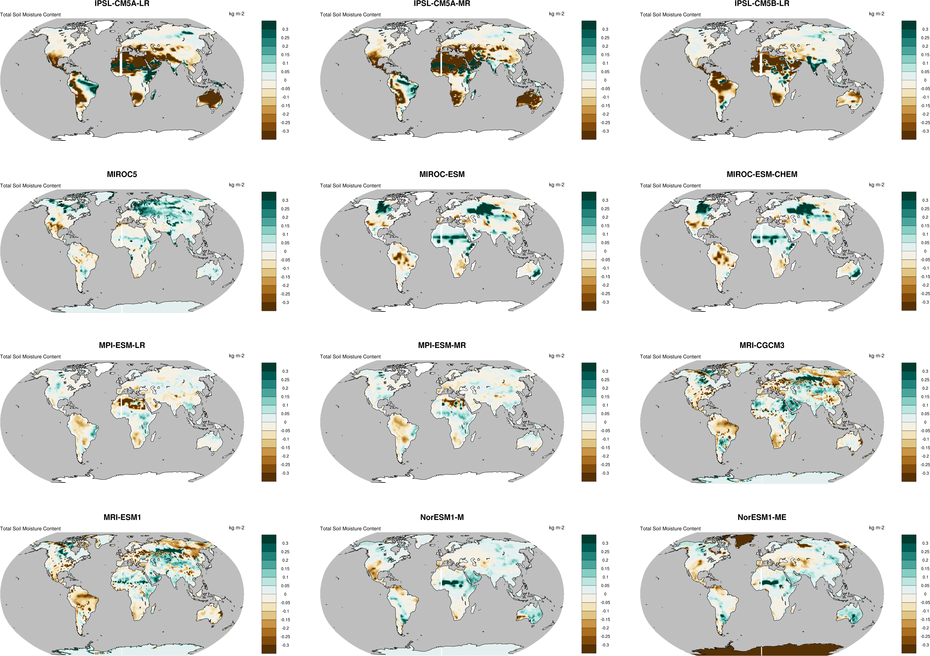

In [19]:
iplot_members(diff, proj='Robinson', N=3, color='MPL_BrBg',
              min=-0.3, max=0.3, delta=0.05, focus='land')

## Compute regional averages per clim_period / GWL

### Function to compute the reginal averages

In [15]:
import regionmask
import xarray as xr

def weighted_mean(da, weights, dim):
    """Reduce da by a weighted mean along some dimension(s).

    Parameters
    ----------
    da : DataArray
        Object over which the weighted reduction operation is applied.    
    weights : DataArray
        An array of weights associated with the values in this Dataset.
    dim : str or sequence of str, optional
        Dimension(s) over which to apply the weighted `mean`.
        
    Returns
    -------
    weighted_mean : DataArray
        New DataArray with weighted mean applied to its data and
        the indicated dimension(s) removed.
    """

    weighted_sum = (da * weights).sum(dim=dim, skipna=True)
    # need to mask weights where data is not valid
    masked_weights = weights.where(da.notnull())
    sum_of_weights = masked_weights.sum(dim=dim, skipna=True)
    valid_weights = sum_of_weights != 0
    sum_of_weights = sum_of_weights.where(valid_weights)

    return weighted_sum / sum_of_weights

def average_over_AR6_region_back(filename, variable, region_name):

    # -- AR6 regions
    #ar6_all = regionmask.defined_regions.ar6.all
    # -- Get the regions
    ar6_land = regionmask.defined_regions.ar6.land

    #ax = ar6_all.plot()
    # -- Get land/sea mask (generic)
    land_110 = regionmask.defined_regions.natural_earth.land_110

    # -- Get data
    ds = xr.open_dataset(filename, decode_times=False)
    dat = ds[variable]
    dat.values = np.array(dat.values, dtype=np.float32)

    # -- Mask the data
    mask_3D = ar6_land.mask_3D(dat) # AR6 mask
    land_mask = land_110.mask_3D(dat) # Land sea mask
    mask_lsm = mask_3D * land_mask.squeeze(drop=True) # Combine the two

    weights = np.cos(np.deg2rad(dat.lat))
    
    if region_name=='all':
        return weighted_mean(dat, mask_lsm * weights, ("lon", "lat"))
    else:
        if isinstance(region_name, list):
            res = list()
            for region in region_name:
                region_mask = mask_lsm.isel(region=list(mask_3D.abbrevs).index(region))
                dat_region = dat.where(region_mask)
                weights_region = weights.where(region_mask)
                res.append( weighted_mean(dat_region, region_mask*weights_region, ("lon","lat")) )
            return res
        else:
            region_mask = mask_lsm.isel(region=list(mask_3D.abbrevs).index(region_name))
            dat_region = dat.where(region_mask)
            weights_region = weights.where(region_mask)            
            return weighted_mean(dat_region, region_mask*weights_region, ("lon","lat"))
    
def average_over_AR6_region(filename, variable, region_name):

    # -- AR6 regions
    #ar6_all = regionmask.defined_regions.ar6.all
    # -- Get the regions
    ar6_land = regionmask.defined_regions.ar6.land

    #ax = ar6_all.plot()
    # -- Get land/sea mask (generic)
    land_110 = regionmask.defined_regions.natural_earth.land_110

    # -- Get data
    ds = xr.open_dataset(filename, decode_times=False)
    dat = ds[variable]
    dat.values = np.array(dat.values, dtype=np.float32)

    # -- Mask the data
    mask_3D = ar6_land.mask_3D(dat) # AR6 mask
    land_mask = land_110.mask_3D(dat) # Land sea mask
    mask_lsm = mask_3D * land_mask.squeeze(drop=True) # Combine the two
    
    # -- Compute weights
    if dat.lat.shape == dat.shape:
        weights = np.cos(np.deg2rad(dat.lat))
    else:
        # -- Case dat is has time dim
        if 'time' in dat.dims:
            matlat = np.mean(dat.values, axis=dat.dims.index('time')) * 0
        else:
            matlat = dat.values * 0

        if dat.dims.index('lat')<dat.dims.index('lon'):
            for i in range(0,dat.shape[dat.dims.index('lon')]):
                matlat[:,i] = dat.lat
        else:
            for i in range(0,dat.shape[dat.dims.index('lon')]):
                matlat[i,:] = dat.lat
    
        weights = np.cos(np.deg2rad(matlat))
    
    if region_name=='all':
        return weighted_mean(dat, mask_lsm * weights, ("lon", "lat"))
    else:
        if isinstance(region_name, list):
            res = list()
            for region in region_name:
                region_mask = mask_lsm.isel(region=list(mask_3D.abbrevs).index(region))
                dat_region = dat.where(region_mask)
                weights_region = np.where(region_mask, weights, float("nan"))
                #weights_region = weights.where(region_mask)
                res.append( weighted_mean(dat_region, region_mask*weights_region, ("lon","lat")) )
            return res
        else:
            region_mask = mask_lsm.isel(region=list(mask_3D.abbrevs).index(region_name))
            dat_region = dat.where(region_mask)
            weights_region = np.where(region_mask, weights, float("nan"))
            #weights_region = weights.where(region_mask)            
            return weighted_mean(dat_region, region_mask*weights_region, ("lon","lat"))
#
def regions_contained(lon, lat, regions):

    # determine if the longitude needs to be wrapped
    regions_is_180 = regions.lon_180
    grid_is_180 = regionmask.core.utils._is_180(lon.min(), lon.max())

    wrap_lon = not regions_is_180 == grid_is_180

    lon_orig = lon.copy()
    if wrap_lon:
        lon = regionmask.core.utils._wrapAngle(lon, wrap_lon)

    lon = np.asarray(lon).squeeze()
    lat = np.asarray(lat).squeeze()

    if lon.ndim == 1 and lat.ndim == 1:
        poly = shapely.geometry.box(lon.min(), lat.min(), lon.max(), lat.max())

    # convex_hull is not really what we need
    # https://gist.github.com/dwyerk/10561690
    #     elif lon.ndim == 2 and lat.ndim == 2:
    #         # get the convex hull from all points
    #         lonlat = np.stack([lon.ravel(), lat.ravel()], axis=1)
    #         multipoint = shapely.geometry.MultiPoint(lonlat)
    #         poly = multipoint.convex_hull
    else:
        raise ValueError("Cannot currently handle 2D coordinates")

    fully_contained = list()
    for region_poly in regions.polygons:
        res = poly.contains(region_poly)

        fully_contained.append(res)

    return xr.DataArray(
        fully_contained, dims=["region"], coords=dict(region=regions.numbers)
    )

if None:
    region_name = "all"
    variable = 'tx35'
    filename = "/data/jservon/IPCC/tx35/individual_models/CMIP6_ssp585_tx35_2100_NorESM2-LM_r1i1p1f1.nc"

    tmp = average_over_AR6_region(filename, variable, region_name)
    tmp

## Regional averages for future periods and baseline

In [19]:
if None:
    regional_averages_CMIP5 = dict()

    # -- Loop on experiments / horizons
    #wind_ens_clim_exp_dict[exp]
    for ens_exp in ens_clim_exp_dict:
        print ens_exp
        regional_averages_CMIP5[ens_exp] = dict()
        # -- Loop on the members of each ensemble
        for mem in ens_clim_exp_dict[ens_exp]:
            print mem
            # -- Compute the averages for each AR6 region thanks to regionmask
            tmp = average_over_AR6_region(cfile(ens_clim_exp_dict[ens_exp][mem]), 'mrso', 'all')
            region_names = tmp.abbrevs
            for tmp_region_name in region_names:
                region_name = str(tmp_region_name.values)
                #print region_name
                region_value = float(tmp.sel(region=list(tmp.abbrevs).index(region_name)).values)
                if region_name not in regional_averages_CMIP5[ens_exp]:
                    regional_averages_CMIP5[ens_exp][region_name] = [region_value]
                else:
                    regional_averages_CMIP5[ens_exp][region_name].append(region_value)
    #
regional_averages_CMIP5 = dict()

# -- Loop on experiments / horizons
for ens_exp in ens_clim_exp_dict:
    print ens_exp
    regional_averages_CMIP5[ens_exp] = dict()
    # -- Loop on the members of each ensemble
    for mem in ens_clim_exp_dict[ens_exp]:
        print mem
        # -- Compute the averages for each AR6 region thanks to regionmask
        tmp = average_over_AR6_region(cfile(ens_clim_exp_dict[ens_exp][mem]), 'mrso', 'all')
        region_names = list(tmp.abbrevs)
        ttmp = average_over_AR6_region(cfile(ens_clim_exp_dict[ens_exp][mem]), 'mrso', region_names)
        for tmp_region_name in region_names:
            region_name = str(tmp_region_name.values)
            region_value = float(ttmp[list(tmp.abbrevs).index(region_name)])
            print region_name, region_value
            if region_name not in regional_averages_CMIP5[ens_exp]:
                regional_averages_CMIP5[ens_exp][region_name] = [region_value]
            else:
                regional_averages_CMIP5[ens_exp][region_name].append(region_value)
#


rcp26_mid
HadGEM2-AO
GIC 151.936340332
NWN 1018.42584229
NEN 991.554382324
WNA 597.195800781
CNA 655.472290039
ENA 767.890075684
NCA 553.793640137
SCA 679.986755371
CAR 548.103149414
NWS 991.264465332


KeyboardInterrupt: 

In [18]:
ens_clim_exp_dict[ens_exp].keys()

['ACCESS1-0',
 'ACCESS1-3',
 'FGOALS-g2',
 'CMCC-CMS',
 'MIROC-ESM',
 'HadGEM2-ES',
 'CMCC-CM',
 'FGOALS-s2',
 'MPI-ESM-MR',
 'CSIRO-Mk3-6-0',
 'CESM1-BGC',
 'HadGEM2-AO',
 'inmcm4',
 'CanESM2',
 'GISS-E2-R-CC',
 'BNU-ESM',
 'CCSM4',
 'GFDL-ESM2G',
 'MRI-CGCM3',
 'GFDL-ESM2M',
 'NorESM1-M',
 'GFDL-CM3',
 'CNRM-CM5',
 'GISS-E2-H',
 'MIROC-ESM-CHEM',
 'MRI-ESM1',
 'NorESM1-ME',
 'MIROC5',
 'GISS-E2-R',
 'HadGEM2-CC',
 'GISS-E2-H-CC',
 'CMCC-CESM',
 'bcc-csm1-1-m',
 'MPI-ESM-LR',
 'bcc-csm1-1',
 'CESM1-CAM5']

In [ ]:
CMCC-CMS 77
MIROC-ESM 2600


ACCESS1-0
ACCESS1-3
FGOALS-g2
CMCC-CMS
MIROC-ESM
HadGEM2-ES
CMCC-CM
FGOALS-s2
MPI-ESM-MR
CSIRO-Mk3-6-0
CESM1-BGC
HadGEM2-AO
inmcm4
CanESM2
GISS-E2-R-CC
BNU-ESM
IPSL-CM5B-LR
GFDL-ESM2G
MRI-CGCM3
GFDL-ESM2M
CCSM4
NorESM1-M
IPSL-CM5A-MR
IPSL-CM5A-LR
GFDL-CM3
CNRM-CM5
GISS-E2-H
MIROC-ESM-CHEM
MRI-ESM1
NorESM1-ME
MIROC5
GISS-E2-R
HadGEM2-CC
GISS-E2-H-CC
CMCC-CESM
bcc-csm1-1-m
MPI-ESM-LR
bcc-csm1-1
CESM1-CAM5

## Differences for future periods against baseline

In [18]:
ens_baseline_dict.keys()

['ACCESS1-0',
 'ACCESS1-3',
 'FGOALS-g2',
 'CMCC-CMS',
 'MPI-ESM-LR',
 'MIROC-ESM',
 'MIROC5',
 'CMCC-CM',
 'FGOALS-s2',
 'MPI-ESM-MR',
 'CSIRO-Mk3-6-0',
 'CESM1-BGC',
 'inmcm4',
 'CanESM2',
 'GISS-E2-R-CC',
 'BNU-ESM',
 'CCSM4',
 'GFDL-ESM2G',
 'bcc-csm1-1-m',
 'GFDL-ESM2M',
 'NorESM1-M',
 'GFDL-CM3',
 'CNRM-CM5',
 'GISS-E2-H',
 'MIROC-ESM-CHEM',
 'bcc-csm1-1',
 'NorESM1-ME',
 'HadGEM2-AO',
 'GISS-E2-R',
 'HadGEM2-CC',
 'GISS-E2-H-CC',
 'CMCC-CESM',
 'MRI-CGCM3',
 'HadGEM2-ES',
 'MRI-ESM1',
 'CESM1-CAM5']

In [20]:
regional_averages_diff_CMIP5 = dict()
# -- Loop on experiments / horizons
#wind_ens_clim_exp_dict[exp]
for ens_exp in ens_clim_exp_dict:
    if ens_exp not in ['baseline']:
        print ens_exp
        regional_averages_diff_CMIP5[ens_exp] = dict()
        # -- Loop on the members of each ensemble
        for mem in ens_clim_exp_dict[ens_exp]:
            if mem.split('_')[0] in ens_baseline_dict:
                print mem
                # -- Compute the averages for each AR6 region thanks to regionmask
                tmp = average_over_AR6_region(cfile(ens_clim_exp_dict[ens_exp][mem]), 'mrso', 'all')
                region_names = list(tmp.abbrevs)
                ttmp = average_over_AR6_region(cfile(ens_clim_exp_dict[ens_exp][mem]), 'mrso', region_names)
                ttmp_baseline = average_over_AR6_region(cfile(ens_clim_exp_dict['baseline'][mem]), 'mrso', region_names)
                for tmp_region_name in region_names:
                    region_name = str(tmp_region_name.values)
                    region_value = float(ttmp[list(tmp.abbrevs).index(region_name)])
                    region_value_baseline = float(ttmp_baseline[list(tmp.abbrevs).index(region_name)])
                    if region_value_baseline==0:
                        if region_value==0:
                            perc_val = 0
                        else:
                            perc_val = -99999
                    else:
                        perc_val = 100*(region_value - region_value_baseline)/region_value_baseline
                    if region_name not in regional_averages_diff_CMIP5[ens_exp]:
                        regional_averages_diff_CMIP5[ens_exp][region_name] = [perc_val]
                    else:
                        regional_averages_diff_CMIP5[ens_exp][region_name].append(perc_val)
#
if None:
    regional_averages_diff_CMIP5 = dict()
    # -- Loop on experiments / horizons
    #wind_ens_clim_exp_dict[exp]
    for ens_exp in ens_clim_exp_dict:
        if ens_exp not in ['baseline']:
            print ens_exp
            regional_averages_diff_CMIP5[ens_exp] = dict()
            # -- Loop on the members of each ensemble
            for mem in ens_clim_exp_dict[ens_exp]:
                if mem.split('_')[0] in ens_baseline_dict:
                    print mem
                    # -- Compute the averages for each AR6 region thanks to regionmask
                    tmp = average_over_AR6_region(cfile(ens_clim_exp_dict[ens_exp][mem]), 'mrso', 'all')
                    tmp_baseline = average_over_AR6_region(cfile(ens_clim_exp_dict['baseline'][mem]), 'mrso', 'all')
                    region_names = tmp.abbrevs
                    for tmp_region_name in region_names:
                        region_name = str(tmp_region_name.values)
                        #print region_name
                        region_value = float(tmp.sel(region=list(tmp.abbrevs).index(region_name)).values)
                        region_value_baseline = float(tmp_baseline.sel(region=list(tmp.abbrevs).index(region_name)).values)
                        if region_value_baseline==0:
                            if region_value==0:
                                perc_val = 0
                            else:
                                perc_val = -99999
                        else:
                            perc_val = 100*(region_value - region_value_baseline)/region_value_baseline
                        if region_name not in regional_averages_diff_CMIP5[ens_exp]:
                            regional_averages_diff_CMIP5[ens_exp][region_name] = [perc_val]
                        else:
                            regional_averages_diff_CMIP5[ens_exp][region_name].append(perc_val)
            #

rcp26_mid
HadGEM2-AO
BNU-ESM
FGOALS-g2
CCSM4
GFDL-ESM2G
bcc-csm1-1-m
GFDL-ESM2M
NorESM1-M
GISS-E2-H
GFDL-CM3
MIROC-ESM
CNRM-CM5
HadGEM2-ES
CanESM2
MIROC-ESM-CHEM
MRI-CGCM3
NorESM1-ME
MIROC5
GISS-E2-R
MPI-ESM-MR
CSIRO-Mk3-6-0
MPI-ESM-LR
bcc-csm1-1
CESM1-CAM5
rcp26_far
HadGEM2-AO
BNU-ESM
FGOALS-g2
CCSM4
GFDL-ESM2G
bcc-csm1-1-m
GFDL-ESM2M
NorESM1-M
GISS-E2-H
GFDL-CM3
MIROC-ESM
CNRM-CM5
HadGEM2-ES
CanESM2
MIROC-ESM-CHEM
MRI-CGCM3
NorESM1-ME
MIROC5
GISS-E2-R
MPI-ESM-MR
CSIRO-Mk3-6-0
MPI-ESM-LR
bcc-csm1-1
CESM1-CAM5
rcp85_far
ACCESS1-0
ACCESS1-3
FGOALS-g2
CMCC-CMS
MIROC-ESM
HadGEM2-ES
CMCC-CM
FGOALS-s2
MPI-ESM-MR
CSIRO-Mk3-6-0
CESM1-BGC
HadGEM2-AO
inmcm4
CanESM2
GISS-E2-R-CC
BNU-ESM
CCSM4
GFDL-ESM2G
MRI-CGCM3
GFDL-ESM2M
NorESM1-M
GFDL-CM3
CNRM-CM5
GISS-E2-H
MIROC-ESM-CHEM
MRI-ESM1
NorESM1-ME
MIROC5
GISS-E2-R
HadGEM2-CC
GISS-E2-H-CC
CMCC-CESM
bcc-csm1-1-m
MPI-ESM-LR
bcc-csm1-1
CESM1-CAM5
rcp85_mid
ACCESS1-0
ACCESS1-3
FGOALS-g2
CMCC-CMS
MIROC-ESM
HadGEM2-ES
CMCC-CM
FGOALS-s2
MPI-ESM-MR
CSIRO-M

## Regional averages for GWLs

In [21]:
if None:
    for GWL in ens_dict_per_GWL :
        print GWL
        regional_averages_CMIP5[GWL] = dict()
        # -- Loop on the members of each ensemble
        for mem in ens_dict_per_GWL[GWL]:
            print mem
            # -- Compute the averages for each AR6 region thanks to regionmask
            tmp = average_over_AR6_region(cfile(ens_dict_per_GWL[GWL][mem]), 'mrso', 'all')
            region_names = list(tmp.abbrevs)
            ttmp = average_over_AR6_region(cfile(ens_dict_per_GWL[GWL][mem]), 'mrso', region_names)
            for tmp_region_name in region_names:
                region_name = str(tmp_region_name.values)
                region_value = float(ttmp[list(tmp.abbrevs).index(region_name)])
                print region_name, region_value
                if region_name not in regional_averages_CMIP5[GWL]:
                    regional_averages_CMIP5[GWL][region_name] = [region_value]
                else:
                    regional_averages_CMIP5[GWL][region_name].append(region_value)

if None:
    for GWL in ens_dict_per_GWL:
        print GWL
        regional_averages_CMIP5[GWL] = dict()
        # -- Loop on the members of each ensemble
        for mem in ens_dict_per_GWL[GWL]:
            print mem
            # -- Compute the averages for each AR6 region thanks to regionmask
            tmp = average_over_AR6_region(cfile(ens_dict_per_GWL[GWL][mem]), 'mrso', 'all')
            region_names = tmp.abbrevs
            for tmp_region_name in region_names:
                region_name = str(tmp_region_name.values)
                #print region_name
                region_value = float(tmp.sel(region=list(tmp.abbrevs).index(region_name)).values)
                if region_name not in regional_averages_CMIP5[GWL]:
                    regional_averages_CMIP5[GWL][region_name] = [region_value]
                else:
                    regional_averages_CMIP5[GWL][region_name].append(region_value)

## Differences for GWLs

In [23]:
for GWL in ens_dict_per_GWL:
    print GWL
    regional_averages_diff_CMIP5[GWL] = dict()
    # -- Loop on the members of each ensemble
    for mem in ens_dict_per_GWL[GWL]:
        wmem = mem.replace('_26','').replace('_85','')
        print wmem
        if wmem in ens_baseline_dict:
            print mem
            tmp = average_over_AR6_region(cfile(ens_dict_per_GWL[GWL][mem]), 'mrso', 'all')
            region_names = list(tmp.abbrevs)
            ttmp = average_over_AR6_region(cfile(ens_dict_per_GWL[GWL][mem]), 'mrso', region_names)
            ttmp_baseline = average_over_AR6_region(cfile(ens_clim_exp_dict['baseline'][wmem]), 'mrso', region_names)
            for tmp_region_name in region_names:
                region_name = str(tmp_region_name.values)
                region_value = float(ttmp[region_names.index(region_name)])
                region_value_baseline = float(ttmp_baseline[region_names.index(region_name)])
                if region_value_baseline==0:
                    if region_value==0:
                        perc_val = 0
                    else:
                        perc_val = -99999
                else:
                    perc_val = 100*(region_value - region_value_baseline)/region_value_baseline
                if region_name not in regional_averages_diff_CMIP5[GWL]:
                    regional_averages_diff_CMIP5[GWL][region_name] = [perc_val]
                else:
                    regional_averages_diff_CMIP5[GWL][region_name].append(perc_val)


if None:
    for GWL in ens_dict_per_GWL:
        print GWL
        regional_averages_diff_CMIP5[GWL] = dict()
        # -- Loop on the members of each ensemble
        for mem in ens_dict_per_GWL[GWL]:
            wmem = mem.replace('_26','').replace('_85','')
            print wmem
            if wmem in ens_baseline_dict:
                print mem
                # -- Compute the averages for each AR6 region thanks to regionmask
                tmp = average_over_AR6_region(cfile(ens_dict_per_GWL[GWL][mem]), 'mrso', 'all')
                tmp_baseline = average_over_AR6_region(cfile(ens_clim_exp_dict['baseline'][wmem]), 'mrso', 'all')
                region_names = tmp.abbrevs
                for tmp_region_name in region_names:
                    region_name = str(tmp_region_name.values)
                    #print region_name
                    region_value = float(tmp.sel(region=list(tmp.abbrevs).index(region_name)).values)
                    region_value_baseline = float(tmp_baseline.sel(region=list(tmp.abbrevs).index(region_name)).values)
                    if region_value_baseline==0:
                        if region_value==0:
                            perc_val = 0
                        else:
                            perc_val = -99999
                    else:
                        perc_val = 100*(region_value - region_value_baseline)/region_value_baseline
                    if region_name not in regional_averages_diff_CMIP5[GWL]:
                        regional_averages_diff_CMIP5[GWL][region_name] = [perc_val]
                    else:
                        regional_averages_diff_CMIP5[GWL][region_name].append(perc_val)


1.5
MPI-ESM-MR
MPI-ESM-MR_26
MIROC5
MIROC5_26
MRI-CGCM3
MRI-CGCM3_85
MPI-ESM-LR
MPI-ESM-LR_85
GFDL-ESM2G
GFDL-ESM2G_85
MPI-ESM-MR
MPI-ESM-MR_85
HadGEM2-CC
HadGEM2-CC_85
CMCC-CM
CMCC-CM_85
CNRM-CM5
CNRM-CM5_26
CMCC-CMS
CMCC-CMS_85
NorESM1-M
NorESM1-M_85
CNRM-CM5
CNRM-CM5_85
MIROC-ESM-CHEM
MIROC-ESM-CHEM_26
CCSM4
CCSM4_26
bcc-csm1-1
bcc-csm1-1_26
ACCESS1-3
ACCESS1-3_85
MPI-ESM-LR
MPI-ESM-LR_26
bcc-csm1-1
bcc-csm1-1_85
MIROC5
MIROC5_85
MIROC-ESM
MIROC-ESM_85
GFDL-CM3
GFDL-CM3_26
MIROC-ESM
MIROC-ESM_26
CESM1-BGC
CESM1-BGC_85
CSIRO-Mk3-6-0
CSIRO-Mk3-6-0_26
GFDL-CM3
GFDL-CM3_85
MIROC-ESM-CHEM
MIROC-ESM-CHEM_85
ACCESS1-0
ACCESS1-0_85
inmcm4
inmcm4_85
HadGEM2-ES
HadGEM2-ES_85
GFDL-ESM2M
GFDL-ESM2M_85
HadGEM2-ES
HadGEM2-ES_26
CSIRO-Mk3-6-0
CSIRO-Mk3-6-0_85
3
MRI-CGCM3
MRI-CGCM3_85
CCSM4
CCSM4_85
GFDL-ESM2G
GFDL-ESM2G_85
MPI-ESM-MR
MPI-ESM-MR_85
HadGEM2-CC
HadGEM2-CC_85
CMCC-CM
CMCC-CM_85
CMCC-CMS
CMCC-CMS_85
GFDL-ESM2M
GFDL-ESM2M_85
CNRM-CM5
CNRM-CM5_85
MPI-ESM-LR
MPI-ESM-LR_85
ACCESS1-3
ACCESS

### Compute the percentiles per region and save in json

In [ ]:
quantiles_dict = dict()
for clim_period in regional_averages_CMIP5:
    quantiles_dict[clim_period] = dict()
    for region_name in regional_averages_CMIP5[clim_period]:
        print clim_period, region_name
        quantiles_dict[clim_period][region_name] = dict()
        dat = np.array(regional_averages_CMIP5[clim_period][region_name])
        q10 = np.quantile(dat, 0.1)
        q50 = np.quantile(dat, 0.5)
        q90 = np.quantile(dat, 0.9)
        quantiles_dict[clim_period][region_name] = [q10, q50, q90]

import json
ensemble = 'CMIP5'
outfilename = '/home/jservon/Chapter12_IPCC/data/Figure_S12.4/'+ensemble+'_SM_AR6_regional_averages.json'
#print outfilename
with open(outfilename, 'w') as fp:
    json.dump(quantiles_dict, fp, sort_keys=True, indent=4)

In [24]:
quantiles_dict = dict()
for clim_period in regional_averages_diff_CMIP5:
    quantiles_dict[clim_period] = dict()
    for region_name in regional_averages_diff_CMIP5[clim_period]:
        print clim_period, region_name
        quantiles_dict[clim_period][region_name] = dict()
        dat = np.array(regional_averages_diff_CMIP5[clim_period][region_name])
        q10 = np.quantile(dat, 0.1)
        q50 = np.quantile(dat, 0.5)
        q90 = np.quantile(dat, 0.9)
        quantiles_dict[clim_period][region_name] = [q10, q50, q90]

import json
ensemble = 'CMIP5'
outfilename = '/home/jservon/Chapter12_IPCC/data/Figure_S12.4/'+ensemble+'_SM_diff_perc2020_AR6_regional_averages.json'
#print outfilename
with open(outfilename, 'w') as fp:
    json.dump(quantiles_dict, fp, sort_keys=True, indent=4)

1.5 NEN
1.5 NCA
1.5 WAN
1.5 EEU
1.5 CAR
1.5 WSAF
1.5 CAU
1.5 WSB
1.5 NAU
1.5 SWS
1.5 NEU
1.5 NES
1.5 TIB
1.5 WNA
1.5 SES
1.5 SAM
1.5 NWS
1.5 NSA
1.5 SCA
1.5 MDG
1.5 CAF
1.5 SEAF
1.5 NZ
1.5 RAR
1.5 SEA
1.5 SAS
1.5 NWN
1.5 EAU
1.5 SAU
1.5 ENA
1.5 WAF
1.5 WCA
1.5 SAH
1.5 GIC
1.5 ESB
1.5 RFE
1.5 CNA
1.5 EAS
1.5 ARP
1.5 MED
1.5 ECA
1.5 NEAF
1.5 EAN
1.5 WCE
1.5 SSA
1.5 ESAF
rcp26_far NEN
rcp26_far NCA
rcp26_far WAN
rcp26_far EEU
rcp26_far CAR
rcp26_far WSAF
rcp26_far CAU
rcp26_far WSB
rcp26_far NAU
rcp26_far SWS
rcp26_far NEU
rcp26_far NES
rcp26_far TIB
rcp26_far WNA
rcp26_far SES
rcp26_far SAM
rcp26_far NWS
rcp26_far NSA
rcp26_far SCA
rcp26_far MDG
rcp26_far CAF
rcp26_far SEAF
rcp26_far NZ
rcp26_far RAR
rcp26_far SEA
rcp26_far SAS
rcp26_far NWN
rcp26_far EAU
rcp26_far SAU
rcp26_far ENA
rcp26_far WAF
rcp26_far WCA
rcp26_far SAH
rcp26_far GIC
rcp26_far ESB
rcp26_far RFE
rcp26_far CNA
rcp26_far EAS
rcp26_far ARP
rcp26_far MED
rcp26_far ECA
rcp26_far NEAF
rcp26_far EAN
rcp26_far WCE
rcp26_far S

/modfs/modtools/miniconda2/envs/analyse_2.7_v2/lib/python2.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)


 ENA
rcp26_mid WAF
rcp26_mid WCA
rcp26_mid SAH
rcp26_mid GIC
rcp26_mid ESB
rcp26_mid RFE
rcp26_mid CNA
rcp26_mid EAS
rcp26_mid ARP
rcp26_mid MED
rcp26_mid ECA
rcp26_mid NEAF
rcp26_mid EAN
rcp26_mid WCE
rcp26_mid SSA
rcp26_mid ESAF
rcp85_far NEN
rcp85_far NCA
rcp85_far WAN
rcp85_far EEU
rcp85_far CAR
rcp85_far WSAF
rcp85_far CAU
rcp85_far WSB
rcp85_far NAU
rcp85_far SWS
rcp85_far NEU
rcp85_far NES
rcp85_far TIB
rcp85_far WNA
rcp85_far SES
rcp85_far SAM
rcp85_far NWS
rcp85_far NSA
rcp85_far SCA
rcp85_far MDG
rcp85_far CAF
rcp85_far SEAF
rcp85_far NZ
rcp85_far RAR
rcp85_far SEA
rcp85_far SAS
rcp85_far NWN
rcp85_far EAU
rcp85_far SAU
rcp85_far ENA
rcp85_far WAF
rcp85_far WCA
rcp85_far SAH
rcp85_far GIC
rcp85_far ESB
rcp85_far RFE
rcp85_far CNA
rcp85_far EAS
rcp85_far ARP
rcp85_far MED
rcp85_far ECA
rcp85_far NEAF
rcp85_far EAN
rcp85_far WCE
rcp85_far SSA
rcp85_far ESAF
3 NEN
3 NCA
3 WAN
3 EEU
3 CAR
3 WSAF
3 CAU
3 WSB
3 NAU
3 SWS
3 NEU
3 NES
3 TIB
3 WNA
3 SES
3 SAM
3 NWS
3 NSA
3 SCA
3 MDG
3